In [1]:
#from time_series import *

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import time
from tqdm import tqdm
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

def get_df(df, zipcode=None, city=None, state_initials=None, metro=None, county=None, start=None, end=None):
    """
    Input: 
    state_initials: string, 2 capital letters
    
    Returns:
    dataframe of zipcodes in the given state.
    """
    data = df
    
    if zipcode != None:
        data = data.loc[(df.RegionName == zipcode)]
    if city != None:
        data = data.loc[(df.City == city)]
    if state_initials != None:
        data = data.loc[(df.State == state_initials)]
    if metro != None: 
        data = data.loc[(df.Metro == metro)]
    if county != None:
        data = data.loc[(df.CountyName == county)]

    data.drop(columns=['RegionID', 'SizeRank'], inplace=True)
    #data.set_index('RegionName', inplace=True)
    head = data.iloc[:,:5]
    tail = data.iloc[:,5:]
    
    if start != None:
        i = tail.columns.get_loc(start)
    else:
        i = None
    if end != None:
        j = tail.columns.get_loc(end) + 1
    else:
        j = None
    tail = tail.iloc[:,i:j]
    
    new_df = pd.concat([head, tail], axis=1)
    new_df.set_index('RegionName', inplace=True)
    
    return new_df

def make_time_series(df):
    ts = pd.DataFrame()
    ts['Month'] = pd.to_datetime(df.columns.values[4:], format='%Y-%m')
    for zipcode in df.index:
        row = df[df.index==zipcode].iloc[:,4:]
        ts[zipcode] = row.values[0]
    ts.set_index('Month',inplace=True)
    return ts

def decompose_time_series(ts):
    decomposition = seasonal_decompose(ts)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    trend.plot(figsize=(20,4),legend=True,title='Trend')
    plt.title("Trend",{'size':22})
    plt.xlabel("Year",{'size':22})
    plt.legend(loc='lower left')
    plt.show()

    seasonal.plot(figsize=(20,4),legend=True,title='Seasonality')
    plt.title("Seasonality",{'size':22})
    plt.xlabel("Year",{'size':22})
    plt.legend(loc='lower left')
    plt.show()

    residual.plot(figsize=(20,4),legend=True,title='Residual')
    plt.title("Residual",{'size':22})
    plt.xlabel("Year",{'size':22})
    plt.legend(loc='lower left')
    plt.show()

def melt_data(df, start_index=0):
    """
    Input zipcode dataframe
    Converts from wide format to long format
    For use with time series modeling
    """
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
                     var_name='Time')
    melted['Time'] = pd.to_datetime(melted['Time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('Time').aggregate({'value':'mean'})[start_index:]

def plot_time_series(df, name=None, legend=None):
    # Instantiate a figure object. 
    plt.figure()
    if not legend:
        legend = list(df.columns)
    # Enumerate through each row in the dataframe passed in. Each row is a different zipcode.
    for ind, row in df.iterrows():
        # Get the median housing value data for the date ranges we want and store in a Series object
        data = pd.Series(row.iloc[7:])
        # Set the appropriate datetimes for data as the index for our data series
        data.index = pd.to_datetime(df.columns[7:])
        # Plot data for current zipcode on figure we instantiated on line 4. Set xticks to corresponding datetimes
        # Also make the figure large, so that we can read it more easily
        ax = data.plot(figsize=(20, 10), xticks=df.columns[7:])
        # add a label
        plt.ylabel("Median House Values")
        # let matplootlib autoformat the datetimes for the xticks
        plt.gcf().autofmt_xdate()
        # If name of city was provided, use it to set title of plot
        if name:
            plt.title("Median Home Value by Zip Code in {} from 1997-2013".format(name))
        else:
            plt.title("Median Home Value, 1997-2013")
    plt.legend(legend)        
    plt.show()


def stationarity_check(df, zipcode, threshold=.01, show_graph=False):
    """
    p-value > 0.05: Fail to reject the null hypothesis, the data is non-stationary.
    p-value <= 0.05: Reject the null hypothesis, the data is stationary.
    """
    # Get time series
    TS = df[zipcode]

    # Calculate rolling statistics
    rolmean = TS.rolling(window = 12, center = False).mean()
    rolstd = TS.rolling(window = 12, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS)
     
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:\n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print('p-value = {}'.format(dfoutput[1]))
    
    if dftest[1] < threshold:
        print('Reject the null hypothesis, the data is stationary.')
    else:
        print('Fail to reject the null hypothesis. \nThe data is non-stationary.')

    if show_graph==True:
        #Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        orig = plt.plot(TS, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
         
    #return dftest[1]

def run_SARIMAX(ts,pdq,pdqs): 
    '''
    Fits a Statsmodels SARIMAX Time Series Model.
    
    Arguments:
         ts    = The time series being modeled.
         pdq   = list containing the p,d,and q values for the SARIMAX function.
         pdqs  = list containing the seasonal p,d and q values along with seasonal 
                 shift amount for the SARIMAX function.
    
    Return Value:
         Dictionary containing {model: model, terms: pdq, seasonal terms: pdqs, AIC: model AIC} values.
         Return AIC of 99999 and model=None indicates that the SARIMAX failed to execute.
    '''
    try:
        mod = sm.tsa.statespace.SARIMAX(ts,
                                       order=pdq,
                                       seasonal_order=pdqs,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False);
        output = mod.fit();
        return {'model':output,'terms':pdq,'seasonal terms':pdqs,'AIC':output.aic}
    
    except:
        return {'model':None,'terms':pdq,'seasonal terms':pdqs,'AIC':99999}

    
def get_SARIMA_parameters(ts,p,d,q,sp,sd,sq,s):
    '''
    Fits a Statsmodels SARIMAX Time Series Model for every combination of
    p,d,q and seasonal p,d,q values provided.
    
    Arguments:
         ts = The time series being modeled.
         p  = list of autoregressive terms to test
         d  = list of differencing parameter terms to test
         q  = list of moving average terms to test
         sp = list of seasonal autoregressive terms to test
         sd = list of seasonal differencing terms to test
         sq = list of seasonal moving average terms to test
         s  = list of seasonal durations to test
         
    Return Value:
         List of dictionaries containing (terms: pdq, seasonal terms: pdqs, AIC: model AIC) values.
         The list is sorted by lowest AIC to highest. 
         AIC of 99999 indicates that the SARIMAX failed to execute.
    '''
    
    #Make combinations of pdq and sp,sd,sq,s for the model
    combos = list(itertools.product(p, d, q))
    combos_seasonal = list(itertools.product(sp, sd, sq, s))
    print('total combos = ',len(combos) * len(combos_seasonal))
    
    #results will be appended to this empty list
    results = []
    
    #iterate through every combination, run a SARIMAX model and store the AIC value
    for combo in tqdm(combos, desc='1st loop'):
        for combo_season in tqdm(combos_seasonal, desc='2nd loop', leave=False):
            time.sleep(3)
            result = run_SARIMAX(ts,combo,combo_season);
            #remove model because this function is only for parameter selection
            del result['model']
            results.append(result);
    
    #return the list sorted by AIC value
    return sorted(results,key=lambda x: x['AIC'])


def get_SARIMA_parameters2(ts,p,d,q,sp,sd,sq,s, trend=None, make_stationary=True, make_invertible=True):
    '''
    Fits a Statsmodels SARIMAX Time Series Model for every combination of
    p,d,q and seasonal p,d,q values provided.
    
    Arguments:
         ts = The time series being modeled.
         p  = list of autoregressive terms to test
         d  = list of differencing parameter terms to test
         q  = list of moving average terms to test
         sp = list of seasonal autoregressive terms to test
         sd = list of seasonal differencing terms to test
         sq = list of seasonal moving average terms to test
         s  = list of seasonal durations to test
         
    Return Value:
         List of dictionaries containing (terms: pdq, seasonal terms: pdqs, AIC: model AIC) values.
         The list is sorted by lowest AIC to highest. 
         AIC of 99999 indicates that the SARIMAX failed to execute.
    '''
    
    #Make combinations of pdq and sp,sd,sq,s for the model
    combos = list(itertools.product(p, d, q))
    combos_seasonal = list(itertools.product(sp, sd, sq, s))
    print('total combos = ',len(combos) * len(combos_seasonal))
    
    #results will be appended to this empty list
    results = []
    #iterate through every combination, run a SARIMAX model and store the AIC value
    for combo in tqdm(combos):
        time.sleep(30)
        for combo_season in combos_seasonal:
            try:
                result = sm.tsa.statespace.SARIMAX(ts,
                                                    order=pdq,
                                                    seasonal_order=pdqs,
                                                    trend=trend,
                                                    enforce_stationarity=make_stationary,
                                                    enforce_invertibility=make_invertible)
                output = result.fit()
                return {'model':output,'terms':pdq,'seasonal terms':pdqs,'AIC':output.aic}

            except:
                return {'model':None,'terms':pdq,'seasonal terms':pdqs,'AIC':99999}
            #remove model because this function is only for parameter selection
            del result['model']
            results.append(result)
    results.sort(key=lambda x: x['AIC'])
    result_pdq = results[0][0]
    
    print(f'Lowest AIC: ARIMA{result_pdq} - AIC: {results[0][1]}')
    return (label, result_pdq)

def find_best_pdq(df, label, pdq):
    """
    Input a dataframe and lists of potential pdq & pdqs values
    Finds combination of pdq/pdqs values that returns lowest AIC
    Returns tuple of label, pdq, and pdqs
    """
    
    results = []
    for params in pdq:
        try:
            model = SARIMAX(endog=df, order=params,
#                                 seasonal_order=seas_params,
                            enforce_stationarity=False, enforce_invertibility=False)
            AIC = model.fit().aic
#             print(f'ARIMA{params}x{seas_params}12 - AIC: {AIC}')
            results.append([params, AIC])
        except:
            continue

    results.sort(key=lambda x: x[-1])
    result_pdq = results[0][0]
#     print(f'Lowest AIC: ARIMA{result_pdq} - AIC: {results[0][1]}')
    return (label, result_pdq)

def plot_prediction(ts,model,date,dynamic=False):
    '''
    Plot a prediction for the time series and model provided.
    
    Arguments:
         ts    = The time series being plotted.
         model = The model being used to make predictions.
         date  = The date after which predictions will be plotted
         dynamic = If True, use dynamic predictions from date provided
         
    Return Value:
         RMSE for the predicitons for the forecast
    
    '''
    pred = model.get_prediction(start=pd.to_datetime(date),dynamic=dynamic,full_results=True)
    pred_conf = pred.conf_int()
    ax = ts.plot(label='observed', figsize=(20,5))
    if dynamic:
        label='dynamic prediction from {}'.format(date)
    else:
        label='one-step-ahead prediction'
    pred.predicted_mean.plot(ax=ax, label=label,color='darkorange',alpha=0.9)
    ax.fill_between(pred_conf.index,pred_conf.iloc[:,0],pred_conf.iloc[:,1],color='b',alpha=0.1)
    plt.legend(loc='upper left')
    forecasted = pred.predicted_mean
    truth = ts[date :]
    RMSE = np.sqrt(np.mean((forecasted-truth)**2))
    print("RMSE: ",RMSE)
    return RMSE


def get_forecast(ts,model,steps,plot=False):
    '''
    Get an ROI 1-yr and 5-yr using a forcast with the time seriex and model provided.
    
    Arguments:
         ts    = The time series being forecasted.
         model = The model being used to make a forecast.
         steps = The number of steps ahead to forecast.
         plot  = If True, plot the forecast
         
    Return Value:
         Dictionary containing 1-yr and 5-yr ROI values.  
    '''
    prediction = model.get_forecast(steps=steps)
    pred_conf = prediction.conf_int()
    
    if plot:    
        #Plot future prediction with confidence interval
        ax = ts.plot(label='observed',figsize=(20,5))
        prediction.predicted_mean.plot(ax=ax,label='forecast')
        ax.fill_between(pred_conf.index,pred_conf.iloc[:,0],pred_conf.iloc[:,1],color='b',alpha=0.1)
        plt.legend(loc='upper left')
        plt.show()
    
    #At least 60 steps are required in order to calculate the 5-yr ROI
    if steps <= 60:
        prediction = model.get_forecast(steps=60)
    
    #Calculate 1yr and 5yr ROIs
    last_val = ts[-1]
    roi_1yr = round( (prediction.predicted_mean[11] - last_val)/last_val , 3)
    roi_5yr = round( (prediction.predicted_mean[59] - last_val)/last_val , 3)
    
    return {'ROI_1yr':roi_1yr, 'ROI_5yr': roi_5yr}


def plot_forecasts(df, model_dicts, steps, title=None):
    '''
    Plot forecasts for all zipcodes in results dictionary.
    
    Arguments:
         df         = The dataframe containing time series data with zipcodes as column names.
         model_dict = List containing dictionaries with models for each zipcode.
         steps      = The number of steps ahead to forecast.
         
    Return Value:
         A plot with all zipcodes in model_dicts  
    '''
    
    for item in model_dicts:
        zipcode = item['zipcode']
        label = f"{item['city']} {zipcode}"
        model = item['model']
        ts = df[zipcode]
        prediction = model.get_forecast(steps=steps)
        all_data = pd.concat([ts,prediction.predicted_mean],axis=0)
        ax = all_data.plot(label=label,figsize=(20,5))
    
    plt.axvline(x=df.index[-1], color='black', linestyle=':')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    return


def pacf_plot(ts,lags=100):
    fig, ax = plt.subplots(figsize=(15,5))
    sm.graphics.tsa.plot_pacf(ts, ax=ax, lags=lags)
    return


def acf_plot(ts,lags=100):
    fig, ax = plt.subplots(figsize=(15,5))
    sm.graphics.tsa.plot_acf(ts, ax=ax, lags=lags)
    return


## Create subset of zipcodes

Load the data stored in `'zillow_data.csv'`. This dataset from Zillow contains housing values by month from 1996 to 2018 for over 14,000 zipcodes across the US. 

In [2]:
df = pd.read_csv('zillow_data.csv')

Use function `get_df()` to easily extract the desired information. Optional location parameters include zipcode, city, state_initials, metro, and county, as well as start and end times. 

In [3]:
dc = get_df(df, state_initials='DC')
dc.head()

,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionName,,,,,,,,,,,,,,,,,,,,,
20002,Washington,DC,Washington,District of Columbia,94300.0,94000.0,93700.0,93600.0,93400.0,93400.0,...,662800,668000,672200,673100,674600,678200,680900,683000,687500,691300
20009,Washington,DC,Washington,District of Columbia,178800.0,179200.0,179600.0,180000.0,180300.0,180700.0,...,1020000,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200
20011,Washington,DC,Washington,District of Columbia,118900.0,118500.0,118200.0,117800.0,117600.0,117400.0,...,582200,586200,591200,593200,591200,589500,590800,599100,611400,619100
20019,Washington,DC,Washington,District of Columbia,91300.0,91000.0,90600.0,90400.0,90100.0,89900.0,...,291100,296300,302500,306700,308800,310800,313400,314100,311800,308600
20001,Washington,DC,Washington,District of Columbia,92000.0,92600.0,93200.0,93900.0,94600.0,95400.0,...,765000,768800,771200,773300,777600,780500,781600,785500,791400,793300


Convert the new subset to time series format using the function `make_time_series()`. This function returns a dataframe with the index as Month and columns for the housing value in each zipcode.

In [4]:
# Convert data to time series format
dc_ts = make_time_series(dc)
dc_ts.head()

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
Month,,,,,,,,,,,,,,,,,,
1996-04-01,94300.0,178800.0,118900.0,91300.0,92000.0,104500.0,450100.0,130000.0,85700.0,362000.0,110500.0,358100.0,209800.0,121700.0,123000.0,277800.0,312400.0,185000.0
1996-05-01,94000.0,179200.0,118500.0,91000.0,92600.0,103800.0,448200.0,130100.0,85500.0,361200.0,111200.0,356000.0,208200.0,121400.0,122400.0,275800.0,311000.0,184900.0
1996-06-01,93700.0,179600.0,118200.0,90600.0,93200.0,103000.0,446300.0,130200.0,85400.0,360300.0,112000.0,353900.0,206600.0,121200.0,121800.0,273700.0,309800.0,184700.0
1996-07-01,93600.0,180000.0,117800.0,90400.0,93900.0,102200.0,444500.0,130400.0,85200.0,359400.0,112900.0,351700.0,205000.0,121000.0,121200.0,271600.0,308700.0,184400.0
1996-08-01,93400.0,180300.0,117600.0,90100.0,94600.0,101400.0,442900.0,130600.0,85000.0,358500.0,113800.0,349600.0,203300.0,120900.0,120700.0,269500.0,307900.0,184100.0


Inspect the new time series dataframe for datatype and null values. 

In [5]:
dc_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 18 columns):
20002    265 non-null float64
20009    265 non-null float64
20011    265 non-null float64
20019    265 non-null float64
20001    265 non-null float64
20020    265 non-null float64
20008    265 non-null float64
20003    265 non-null float64
20032    265 non-null float64
20016    265 non-null float64
20010    265 non-null float64
20007    265 non-null float64
20024    265 non-null float64
20017    265 non-null float64
20018    265 non-null float64
20037    265 non-null float64
20015    265 non-null float64
20012    265 non-null float64
dtypes: float64(18)
memory usage: 39.3 KB


In [6]:
print('Count of null values:')
dc_ts.isna().sum()

Count of null values:


20002    0
20009    0
20011    0
20019    0
20001    0
20020    0
20008    0
20003    0
20032    0
20016    0
20010    0
20007    0
20024    0
20017    0
20018    0
20037    0
20015    0
20012    0
dtype: int64

**Observations**

This subset does not require any preprocessing. All data is stored as float and there are no null values. 

## Visualize data

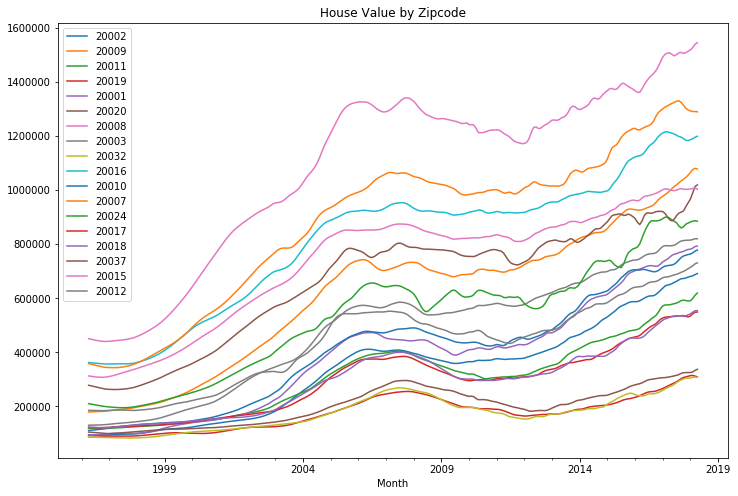

In [7]:
# Plot timeseries of house value by zipcode
dc_ts.plot(figsize=(12,8))
plt.title('House Value by Zipcode')
plt.show()

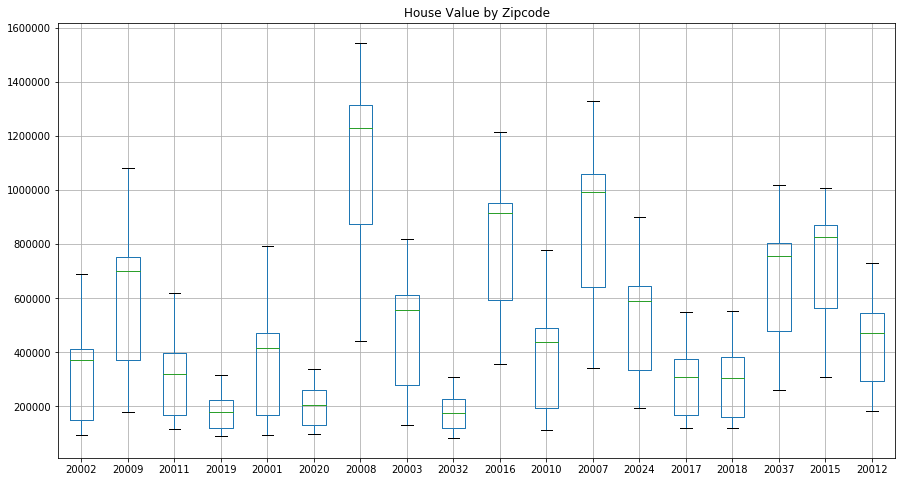

In [8]:
# Generate a box and whiskers plot for each zipcode
dc_ts.boxplot(figsize = (15,8))
plt.title('House Value by Zipcode')
plt.show()

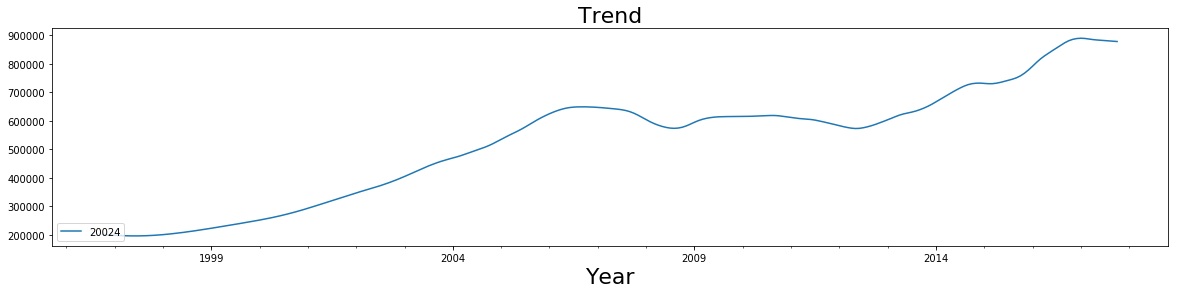

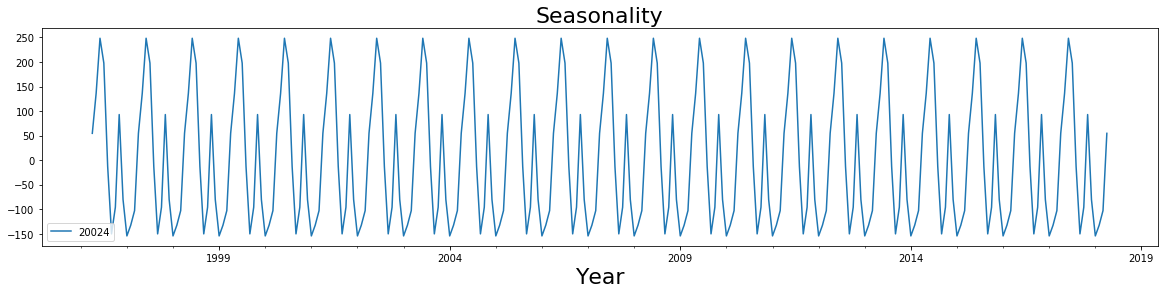

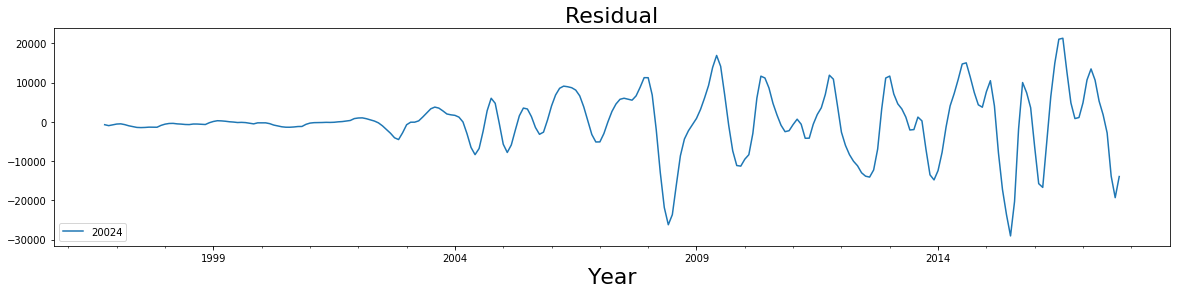

In [9]:
# Decompose one zipcode
decompose_time_series(dc_ts[20024])

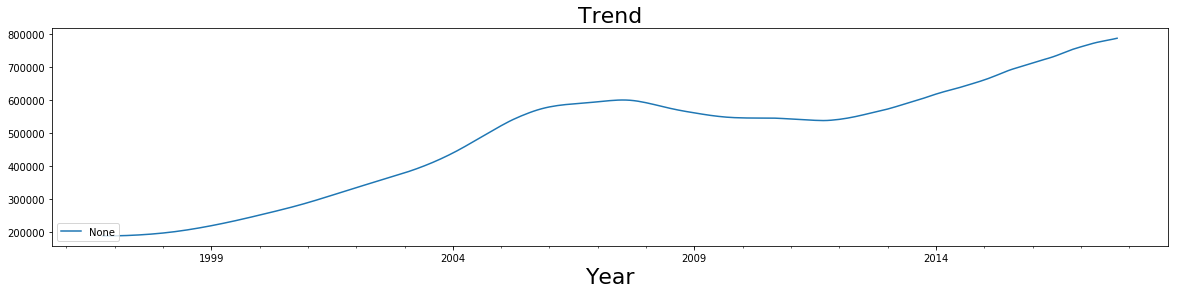

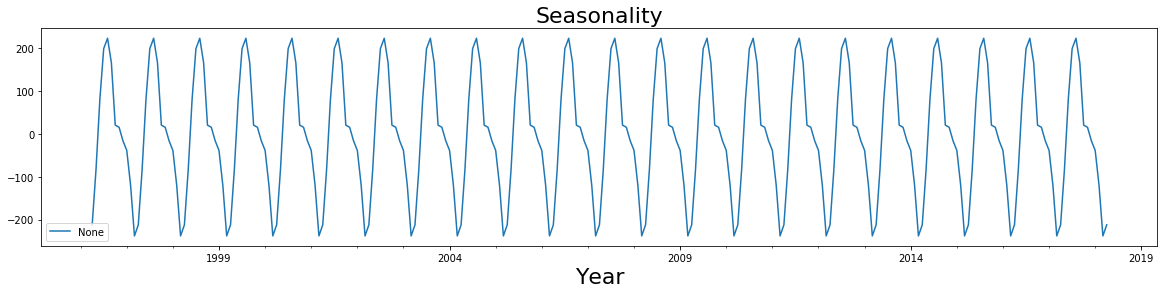

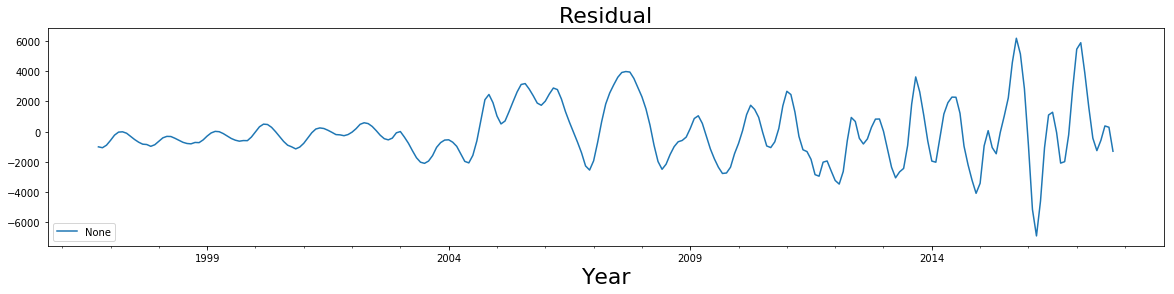

In [10]:
# Decompose by mean value of region
decompose_time_series(dc_ts.mean(axis=1))

In [11]:
import seaborn as sns

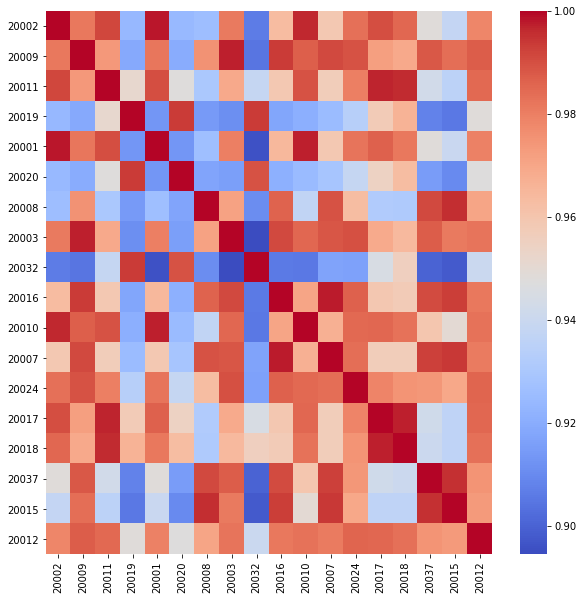

In [12]:
corr = dc_ts.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='coolwarm')

## Experimental Test Set Up

## Optimize parameters

In [5]:
split_date = -12
X, y = dc_ts[:split_date], dc_ts[split_date:]
print("Train: %s \tTest: %s" % (len(X), len(y)))

Train: 253 	Test: 12


In [8]:
zipcodes = list(dc_ts.columns)
#tscv = TimeSeriesSplit(n_splits=3)
print(tscv)  
for zipcode in zipcodes:
    

In [35]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    # fit model
    model = sm.tsa.SARIMAX(history, order=(1,1,2), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    # one step forecast
    yhat = model_fit.forecast()[0]
    # store forecast and ob
    predictions.append(yhat)
    history.append(test[t])
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

ValueError: maxlag should be < nobs

In [29]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [30]:
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)  
rmse = []
for train, test in tscv.split(X):
    print("\nTrain: %s \tTest: %s" % (train.size, test.size))
    sarimax = sm.tsa.SARIMAX(train, order=(1,1,2), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
    model = sarimax.fit()
    predictions = model.predict(test[0], test[-1])
    true_values = test
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    print("RMSE: {}".format(np.mean(rmse)))


TimeSeriesSplit(max_train_size=None, n_splits=3)

Train: 61 	Test: 59
RMSE: 0.0

Train: 120 	Test: 59
RMSE: 0.0

Train: 179 	Test: 59
RMSE: 0.0


In [115]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

Results of Dickey-Fuller Test:

p-value = 0.7067373400486674
Fail to reject the null hypothesis. 
The data is non-stationary.


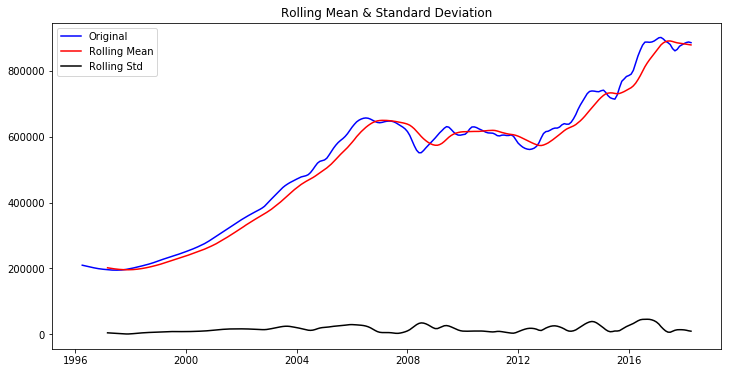

In [13]:
stationarity_check(dc_ts, 20024, show_graph=True)

Results of Dickey-Fuller Test:

p-value = 0.09228729546203374
Fail to reject the null hypothesis. 
The data is non-stationary.


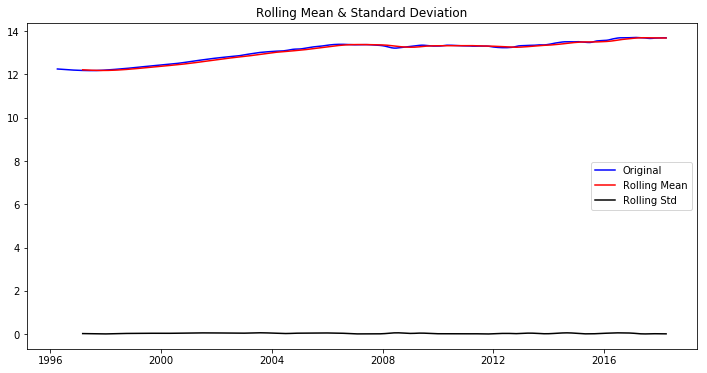

In [11]:
dc_log = np.log(dc_ts)
stationarity_check(dc_log, 20024, show_graph=True)

Results of Dickey-Fuller Test:

p-value = 0.17824603050954474
Fail to reject the null hypothesis. 
The data is non-stationary.


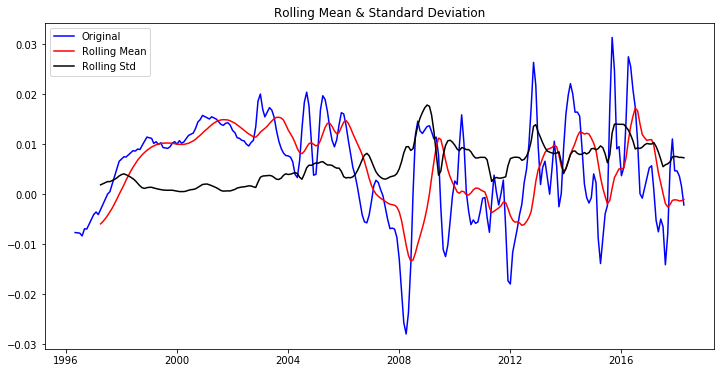

In [12]:
dc_log_diff = dc_log.diff(periods=1).dropna()
stationarity_check(dc_log_diff, 20024, show_graph=True)

Results of Dickey-Fuller Test:

p-value = 0.07644302430492506
Fail to reject the null hypothesis. 
The data is non-stationary.


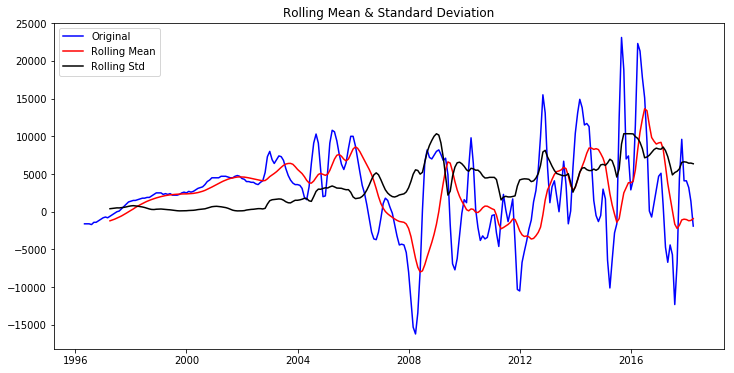

In [13]:
dc_diff = dc_ts.diff(periods=1).dropna()
stationarity_check(dc_diff, 20024, show_graph=True)

Results of Dickey-Fuller Test:

p-value = 0.07644302430492506
Fail to reject the null hypothesis. 
The data is non-stationary.


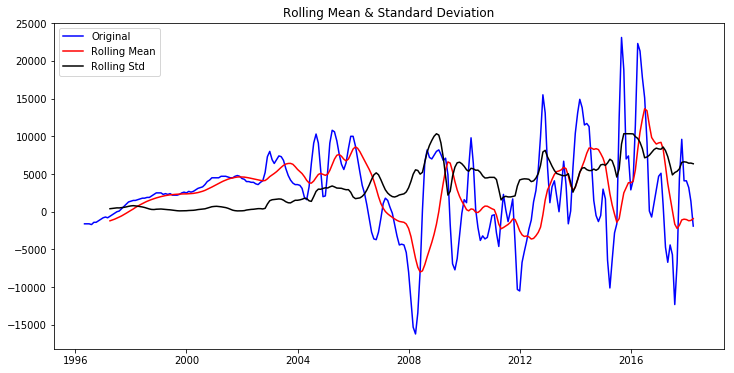

In [14]:
dc_diff2 = dc_ts.diff(periods=1).dropna()
stationarity_check(dc_diff2, 20024, show_graph=True)

In [37]:
zipcode = dc_ts[20024]

In [38]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zipcode,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
output.summary()
#display(output.summary().tables[0], output.summary().tables[1], output.summary().tables[2])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20024   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2389.078
Date:                            Tue, 13 Aug 2019   AIC                           4784.155
Time:                                    16:59:38   BIC                           4794.572
Sample:                                04-01-1996   HQIC                          4788.354
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7411      0.056     13.174      0.000       0.631       0.851
ma.S.L12      -0.2662      0.060     -4.415      0.000      -0.384      -0.148
sigma2      4.689e+07   1.77e-10   2.65e+17      0.000    4.69e+07    4.69e+07
===================================================================================
Ljung-Box (Q):                      292.88   Jarque-Bera (JB):                13.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.61   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.55e+34. Standard errors may be unstable.
"""

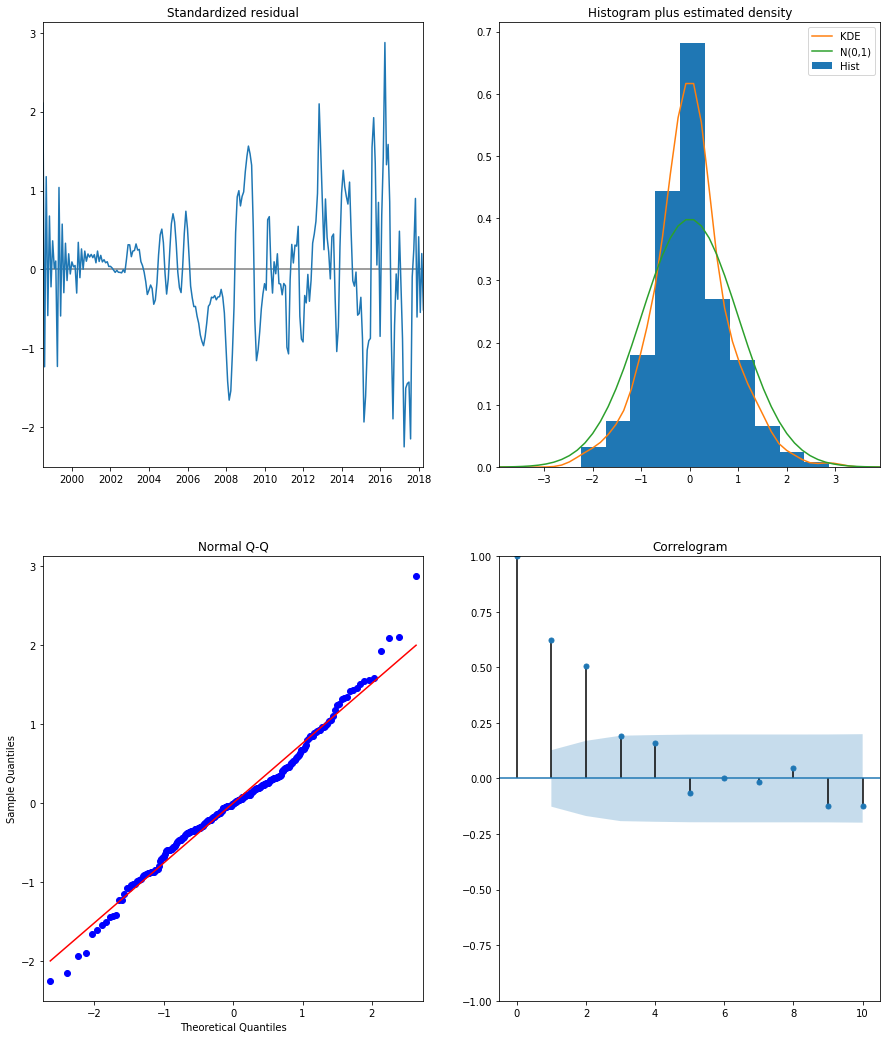

In [39]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

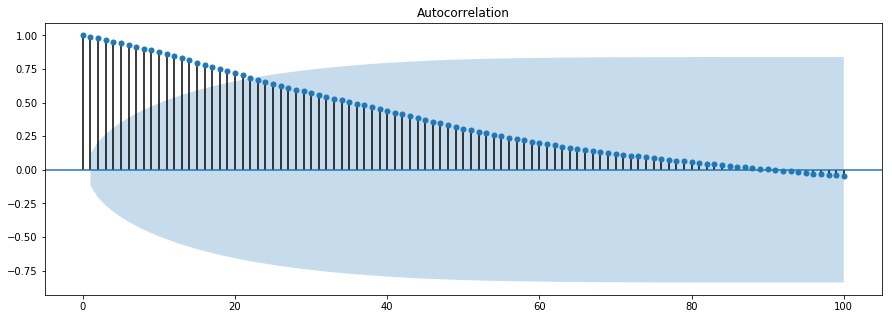

In [25]:
acf_plot(dc_ts[20024])

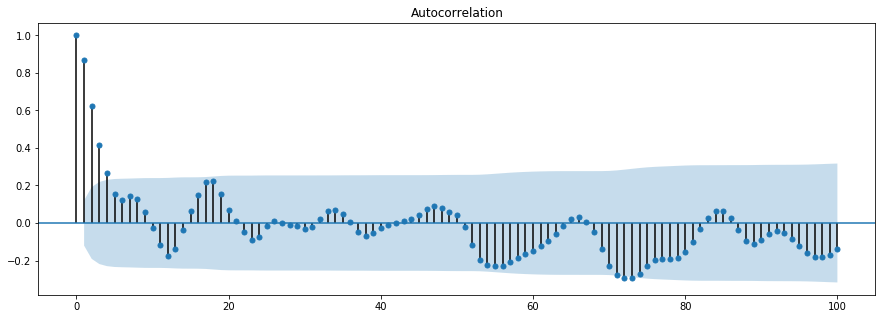

In [26]:
acf_plot(dc_diff[20024])

In [74]:
split_date = '2018-01'
train, test = dc_ts[:split_date], dc_ts[split_date:]

In [30]:
#ARIMA MODELING PARAMETERS
#Using s=12 because this is monthly data with yearly cycles
p = [0,1,2,3]
d = [0,1,2]
q = [0,1,2,3]

sp = [0,1,2]
sd = [0,1,2]
sq = [0,1,2]
s = [12]

#sp+sq<=2
#d+sd <=2

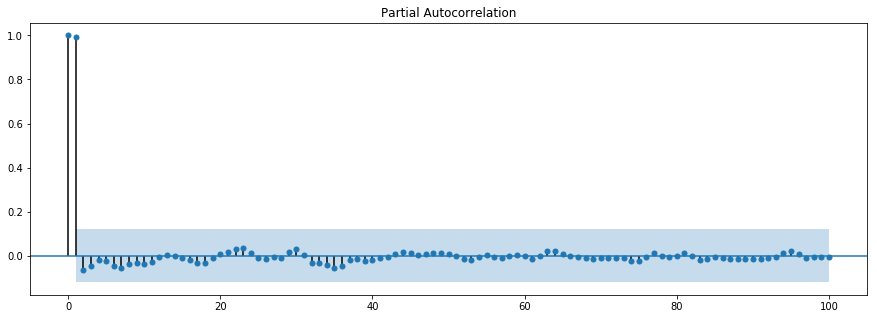

In [31]:
pacf_plot(train[20024])

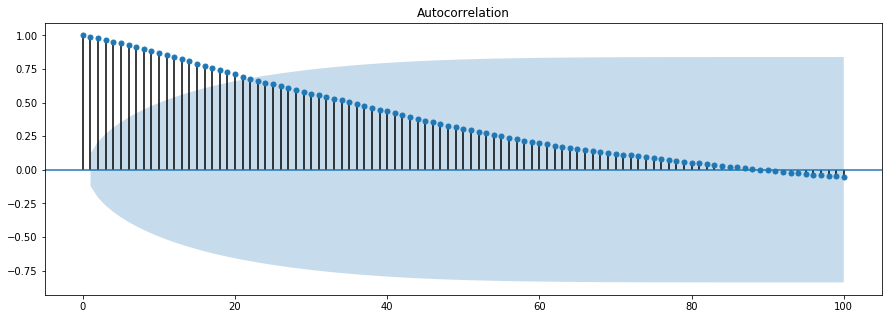

In [32]:
acf_plot(train[20024])

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

In [20]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [53]:
lag_acf = acf(ts, nlags=20)
lag_pacf = pacf(ts, nlags=20, method='ols')

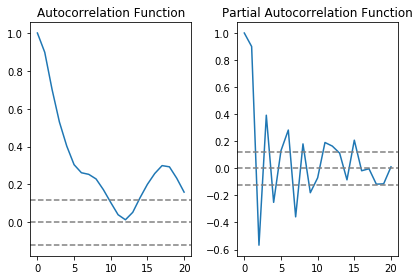

In [54]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

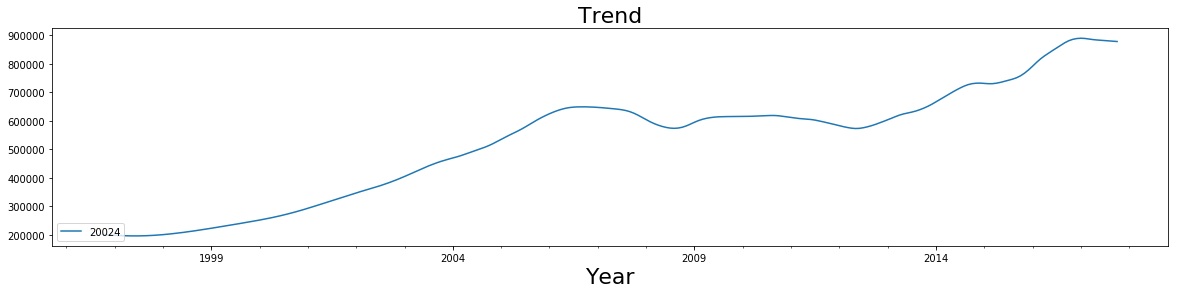

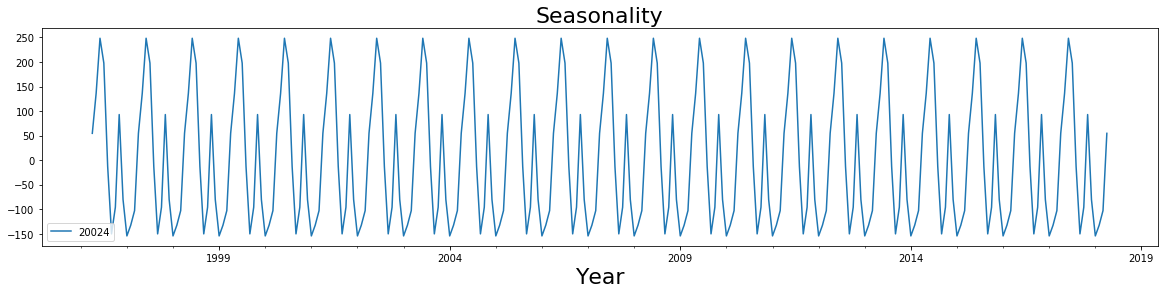

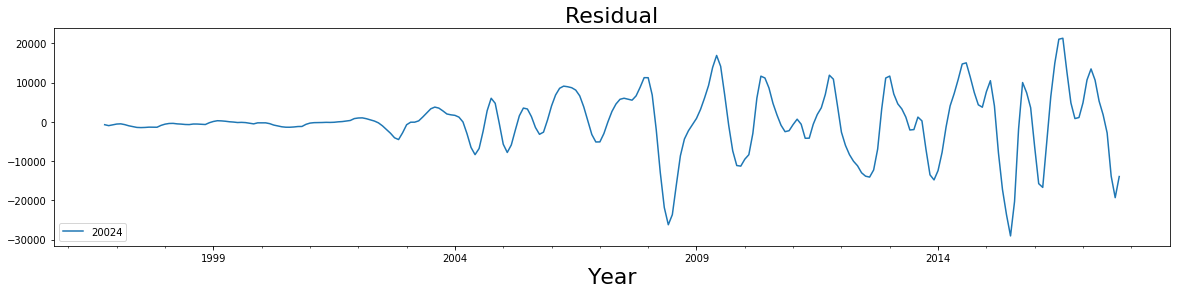

In [40]:
decompose_time_series(dc_ts[20024])

### Number of AR (Auto-Regressive) terms (p):
p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (d):
d is the Integrated component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last n days is small.

### Number of MA (Moving Average) terms (q):
q is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

* (p, d, q) are the non-seasonal parameters described above.
* (P, D, Q) follow the same definition but are applied to the seasonal component of the time series.
* The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).


In [83]:
def param_combos():
    p = [0,1,2,3]
    d = [0,1,2]
    q = [0,1,2,3]

    sp = [0,1,2]
    sd = [0,1,2]
    sq = [0,1,2]
    s = [12]
    #Make combinations of pdq and sp,sd,sq,s for the model
    combos = list(itertools.product(p, d, q, sp, sd, sq, s))
    print('total combos = ',len(combos))
    
    for i, combo in enumerate(combos):
        if combo[1] + combo[4] > 2:
            combos.remove(combos[i])
        else:
            continue
    print('total combos = ',len(combos))
    return combos

In [86]:
c = param_combos()
c[:5]

total combos =  1296
total combos =  1056


[(0, 0, 0, 0, 0, 0, 12),
 (0, 0, 0, 0, 0, 1, 12),
 (0, 0, 0, 0, 0, 2, 12),
 (0, 0, 0, 0, 1, 0, 12),
 (0, 0, 0, 0, 1, 1, 12)]

In [26]:
results = get_SARIMA_parameters(train[20024],p,d,q,sp,sd,sq,s)



1st loop:   0%|          | 0/48 [00:00<?, ?it/s]


2nd loop:   0%|          | 0/27 [00:00<?, ?it/s]

total combos =  1296





2nd loop:   4%|▎         | 1/27 [00:03<01:18,  3.03s/it]


2nd loop:   7%|▋         | 2/27 [00:06<01:16,  3.06s/it]


2nd loop:  11%|█         | 3/27 [00:11<01:26,  3.60s/it]


2nd loop:  15%|█▍        | 4/27 [00:14<01:18,  3.43s/it]


2nd loop:  19%|█▊        | 5/27 [00:17<01:18,  3.57s/it]


2nd loop:  22%|██▏       | 6/27 [00:24<01:33,  4.47s/it]


2nd loop:  26%|██▌       | 7/27 [00:27<01:21,  4.05s/it]


2nd loop:  30%|██▉       | 8/27 [00:32<01:22,  4.32s/it]


2nd loop:  33%|███▎      | 9/27 [00:37<01:21,  4.53s/it]


2nd loop:  37%|███▋      | 10/27 [00:40<01:09,  4.09s/it]


2nd loop:  41%|████      | 11/27 [00:43<01:01,  3.84s/it]


2nd loop:  44%|████▍     | 12/27 [00:48<01:01,  4.09s/it]


2nd loop:  48%|████▊     | 13/27 [00:51<00:53,  3.79s/it]


2nd loop:  52%|█████▏    | 14/27 [00:55<00:48,  3.77s/it]


2nd loop:  56%|█████▌    | 15/27 [01:05<01:09,  5.82s/it]


2nd loop:  59%|█████▉    | 16/27 [01:09<00:55,  5.03s/it]


2nd loop:  63%|██████▎   | 17/27 [01:13<00:47,

1st loop:  17%|█▋        | 8/48 [23:08<1:52:00, 168.01s/it]


2nd loop:   0%|          | 0/27 [00:00<?, ?it/s]


2nd loop:   4%|▎         | 1/27 [00:03<01:18,  3.02s/it]


2nd loop:   7%|▋         | 2/27 [00:06<01:16,  3.06s/it]


2nd loop:  11%|█         | 3/27 [00:09<01:16,  3.20s/it]


2nd loop:  15%|█▍        | 4/27 [00:12<01:12,  3.16s/it]


2nd loop:  19%|█▊        | 5/27 [00:16<01:10,  3.19s/it]


2nd loop:  22%|██▏       | 6/27 [00:23<01:35,  4.53s/it]


2nd loop:  26%|██▌       | 7/27 [00:26<01:22,  4.12s/it]


2nd loop:  30%|██▉       | 8/27 [00:30<01:14,  3.90s/it]


2nd loop:  33%|███▎      | 9/27 [00:35<01:15,  4.20s/it]


2nd loop:  37%|███▋      | 10/27 [00:38<01:05,  3.86s/it]


2nd loop:  41%|████      | 11/27 [00:41<00:58,  3.66s/it]


2nd loop:  44%|████▍     | 12/27 [00:45<00:56,  3.76s/it]


2nd loop:  48%|████▊     | 13/27 [00:48<00:49,  3.56s/it]


2nd loop:  52%|█████▏    | 14/27 [00:51<00:45,  3.51s/it]


2nd loop:  56%|█████▌    | 15/27 [00:59<00:55,  4.65s/it

2nd loop: 100%|██████████| 27/27 [04:16<00:00, 17.69s/it]


                                                         

1st loop:  33%|███▎      | 16/48 [46:14<1:48:12, 202.90s/it]


2nd loop:   0%|          | 0/27 [00:00<?, ?it/s]


2nd loop:   4%|▎         | 1/27 [00:03<01:19,  3.05s/it]


2nd loop:   7%|▋         | 2/27 [00:06<01:16,  3.07s/it]


2nd loop:  11%|█         | 3/27 [00:09<01:17,  3.23s/it]


2nd loop:  15%|█▍        | 4/27 [00:12<01:14,  3.22s/it]


2nd loop:  19%|█▊        | 5/27 [00:16<01:11,  3.26s/it]


2nd loop:  22%|██▏       | 6/27 [00:20<01:14,  3.54s/it]


2nd loop:  26%|██▌       | 7/27 [00:23<01:09,  3.45s/it]


2nd loop:  30%|██▉       | 8/27 [00:27<01:07,  3.53s/it]


2nd loop:  33%|███▎      | 9/27 [00:34<01:19,  4.43s/it]


2nd loop:  37%|███▋      | 10/27 [00:37<01:08,  4.02s/it]


2nd loop:  41%|████      | 11/27 [00:40<01:00,  3.77s/it]


2nd loop:  44%|████▍     | 12/27 [00:44<00:57,  3.81s/it]


2nd loop:  48%|████▊     | 13/27 [00:47<00:50,  3.63s/it

2nd loop:  93%|█████████▎| 25/27 [03:16<00:24, 12.11s/it]


2nd loop:  96%|█████████▋| 26/27 [03:31<00:13, 13.00s/it]


2nd loop: 100%|██████████| 27/27 [03:55<00:00, 16.21s/it]


                                                         

1st loop:  50%|█████     | 24/48 [1:08:01<1:14:40, 186.68s/it]


2nd loop:   0%|          | 0/27 [00:00<?, ?it/s]


2nd loop:   4%|▎         | 1/27 [00:03<01:19,  3.07s/it]


2nd loop:   7%|▋         | 2/27 [00:06<01:19,  3.17s/it]


2nd loop:  11%|█         | 3/27 [00:12<01:33,  3.91s/it]


2nd loop:  15%|█▍        | 4/27 [00:15<01:24,  3.69s/it]


2nd loop:  19%|█▊        | 5/27 [00:20<01:31,  4.17s/it]


2nd loop:  22%|██▏       | 6/27 [00:30<02:03,  5.90s/it]


2nd loop:  26%|██▌       | 7/27 [00:33<01:42,  5.14s/it]


2nd loop:  30%|██▉       | 8/27 [00:41<01:50,  5.84s/it]


2nd loop:  33%|███▎      | 9/27 [00:49<01:56,  6.49s/it]


2nd loop:  37%|███▋      | 10/27 [00:52<01:33,  5.49s/it]


2nd loop:  41%|████      | 11/27 [00:56<01:20,  5.01s/

2nd loop:  85%|████████▌ | 23/27 [02:42<00:30,  7.70s/it]


2nd loop:  89%|████████▉ | 24/27 [02:59<00:31, 10.48s/it]


2nd loop:  93%|█████████▎| 25/27 [03:10<00:21, 10.61s/it]


2nd loop:  96%|█████████▋| 26/27 [03:25<00:11, 11.75s/it]


2nd loop: 100%|██████████| 27/27 [03:46<00:00, 14.71s/it]


                                                         

1st loop:  67%|██████▋   | 32/48 [1:35:21<53:02, 198.88s/it]


2nd loop:   0%|          | 0/27 [00:00<?, ?it/s]


2nd loop:   4%|▎         | 1/27 [00:03<01:18,  3.03s/it]


2nd loop:   7%|▋         | 2/27 [00:06<01:17,  3.09s/it]


2nd loop:  11%|█         | 3/27 [00:10<01:19,  3.32s/it]


2nd loop:  15%|█▍        | 4/27 [00:13<01:14,  3.25s/it]


2nd loop:  19%|█▊        | 5/27 [00:18<01:24,  3.85s/it]


2nd loop:  22%|██▏       | 6/27 [00:27<01:51,  5.29s/it]


2nd loop:  26%|██▌       | 7/27 [00:30<01:32,  4.63s/it]


2nd loop:  30%|██▉       | 8/27 [00:34<01:26,  4.57s/it]


2nd loop:  33%|███▎      | 9/27 [00:40<01:31,  5.10s/it

2nd loop:  78%|███████▊  | 21/27 [03:27<01:04, 10.74s/it]


2nd loop:  81%|████████▏ | 22/27 [03:44<01:02, 12.59s/it]


2nd loop:  85%|████████▌ | 23/27 [04:05<01:00, 15.12s/it]


2nd loop:  89%|████████▉ | 24/27 [04:25<00:50, 16.76s/it]


2nd loop:  93%|█████████▎| 25/27 [04:42<00:33, 16.60s/it]


2nd loop:  96%|█████████▋| 26/27 [05:12<00:20, 20.70s/it]


2nd loop: 100%|██████████| 27/27 [05:43<00:00, 23.89s/it]


                                                         

1st loop:  83%|████████▎ | 40/48 [2:08:33<38:14, 286.82s/it]


2nd loop:   0%|          | 0/27 [00:00<?, ?it/s]


2nd loop:   4%|▎         | 1/27 [00:03<01:19,  3.06s/it]


2nd loop:   7%|▋         | 2/27 [00:06<01:17,  3.10s/it]


2nd loop:  11%|█         | 3/27 [00:10<01:19,  3.32s/it]


2nd loop:  15%|█▍        | 4/27 [00:13<01:15,  3.28s/it]


2nd loop:  19%|█▊        | 5/27 [00:16<01:14,  3.40s/it]


2nd loop:  22%|██▏       | 6/27 [00:21<01:20,  3.83s/it]


2nd loop:  26%|██▌       | 7/27 [00:25<01:14,  3.72s/

2nd loop:  70%|███████   | 19/27 [04:01<02:12, 16.51s/it]


2nd loop:  74%|███████▍  | 20/27 [04:08<01:35, 13.64s/it]


2nd loop:  78%|███████▊  | 21/27 [04:16<01:11, 11.84s/it]


2nd loop:  81%|████████▏ | 22/27 [04:32<01:06, 13.22s/it]


2nd loop:  85%|████████▌ | 23/27 [04:47<00:54, 13.74s/it]


2nd loop:  89%|████████▉ | 24/27 [05:14<00:52, 17.63s/it]


2nd loop:  93%|█████████▎| 25/27 [05:38<00:39, 19.59s/it]


2nd loop:  96%|█████████▋| 26/27 [06:05<00:21, 21.70s/it]


2nd loop: 100%|██████████| 27/27 [07:02<00:00, 32.30s/it]


                                                         

1st loop: 100%|██████████| 48/48 [2:43:31<00:00, 320.71s/it]

In [40]:
results[0]

{'terms': (1, 2, 3),
 'seasonal terms': (2, 2, 2, 12),
 'AIC': 4042.3871808739323}

In [38]:
narrow = []
for result in results:
    if result['terms'][1] + result['seasonal terms'][1] <= 2:
        narrow.append(result)
    else:
        continue

In [39]:
narrow

[{'terms': (2, 1, 2),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 4109.938594332395},
 {'terms': (2, 1, 2),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 4112.9029392587345},
 {'terms': (2, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 4118.83749569931},
 {'terms': (3, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 4119.7164372083935},
 {'terms': (3, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 4121.096658431612},
 {'terms': (1, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 4122.884168865343},
 {'terms': (1, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 4123.122097664125},
 {'terms': (2, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 4124.274199627414},
 {'terms': (3, 1, 2),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 4141.467082254232},
 {'terms': (3, 1, 2),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 4141.709633427672},
 {'terms': (3, 0, 3),
  'seasonal terms': (2, 2, 0, 12),
  'AIC': 4143.2278966007025},
 {'terms': (1, 1, 2),
  'seasonal terms': (0, 1, 2, 

In [88]:
pdq   = narrow[0]['terms']
pdqs  = narrow[0]['seasonal terms']

#model = run_SARIMAX(ts,pdq,pdqs, stationary=True)
#['model']
#model.summary()

model = sm.tsa.statespace.SARIMAX(ts, order=pdq, seasonal_order=pdqs,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20024   No. Observations:                  264
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 916.128
Date:                            Sun, 11 Aug 2019   AIC                          -1816.256
Time:                                    22:47:28   BIC                          -1788.963
Sample:                                05-01-1996   HQIC                         -1805.240
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6809      0.173      3.937      0.000       0.342       1.020
ar.L2         -0.4108      0.071     -5.756      0.000      -0.551      -0.271
ma.L1          0.1825      0.179      1.018      0.309      -0.169       0.534
ma.L2         -0.0840      0.141     -0.594      0.552      -0.361       0.193
ar.S.L12      -0.5603      0.773     -0.725      0.468      -2.075       0.955
ma.S.L12      -1.0499      1.071     -0.980      0.327      -3.149       1.049
ma.S.L24      -0.7280      1.211     -0.601      0.548      -3.101       1.645
sigma2      6.963e-06   2.21e-06      3.155      0.002    2.64e-06    1.13e-05
===================================================================================
Ljung-Box (Q):                      176.38   Jarque-Bera (JB):               260.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.53   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

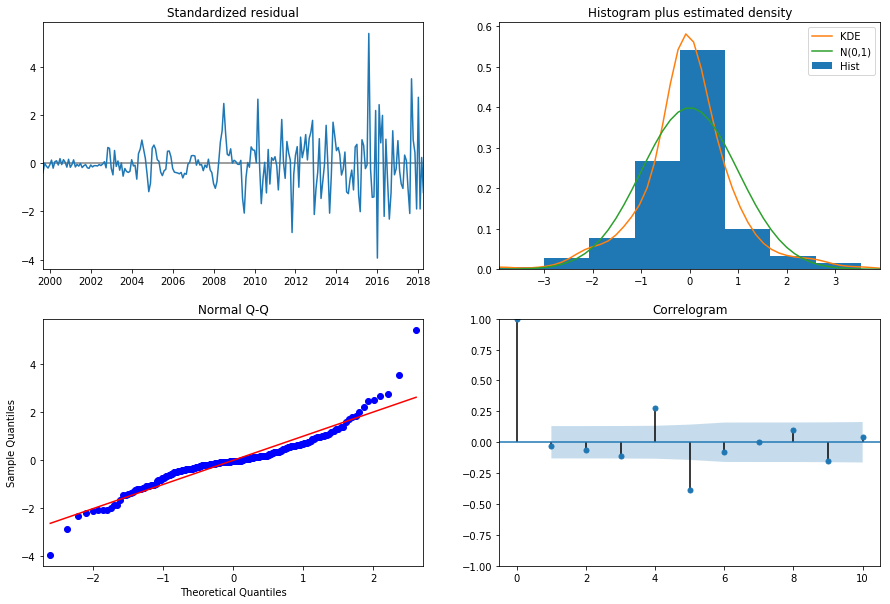

In [89]:
result.plot_diagnostics(figsize=(15,10));

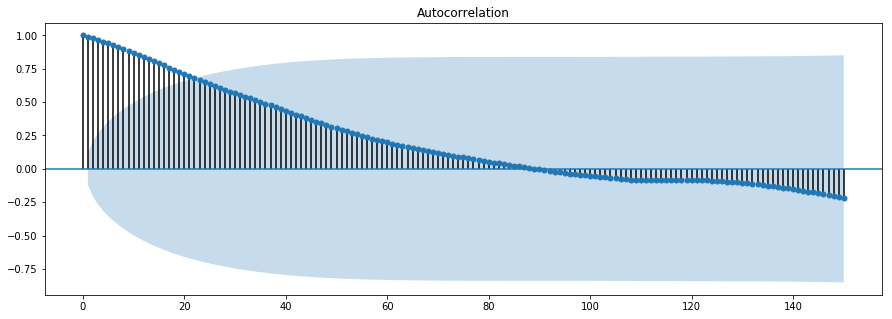

In [92]:
acf_plot(train[20024],lags=150)

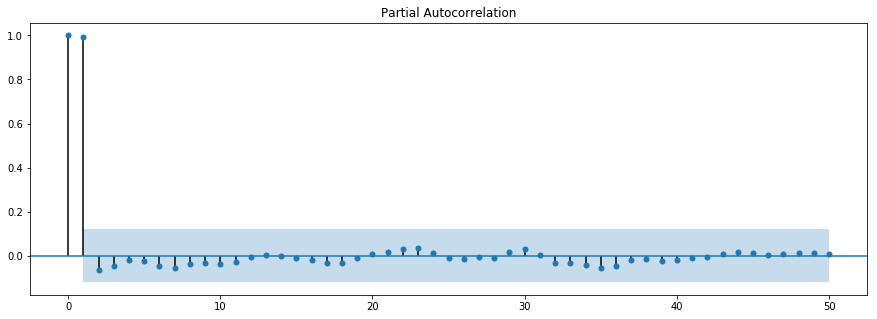

In [93]:
pacf_plot(train[20024],lags=50)

In [94]:
plot_prediction(ts['2009':],model,'2014', dynamic=False)
plt.ylabel('$',{'size':22});

AttributeError: 'SARIMAX' object has no attribute 'get_prediction'

In [95]:
plot_prediction(ts['2009':],model,'2014',dynamic=True)
plt.ylabel('$',{'size':22});

AttributeError: 'SARIMAX' object has no attribute 'get_prediction'

In [96]:
get_forecast(ts['2009':],model,60,plot=True)

AttributeError: 'SARIMAX' object has no attribute 'get_forecast'

In [ ]:
results = []

steps = 60

for zipcode in dc_log.columns:
    zipcode_model = run_SARIMAX(dc_log[zipcode].dropna(),pdq,pdqs)['model']
    if zipcode_model==None:
        continue
    result = get_forecast(dc_log[zipcode],zipcode_model,steps,plot=False)
    result['zipcode'] = zipcode
    result['model'] = zipcode_model
    location_info = df.loc[df.RegionName==zipcode,['City','State']].values
    label = f"{location_info[0][0]},{location_info[0][1]}"
    result['city'] = label
    results.append(result)
results = sorted(results,key=lambda x: x['ROI_5yr'],reverse=True)

In [ ]:
results_df = pd.DataFrame(results)
results_df.drop(columns=['model'],inplace=True)
results_df.head()

In [ ]:
plot_forecasts(dc_log,sorted_results[0:5],steps=60,title='Highest 5-year ROI Zipcodes')

In [ ]:
for result in results[0:5]:
    print(result['city'])
    get_forecast(dc_log[result['zipcode']],result['model'],60,plot=True)

### Cross Validation

In [39]:
!pip install joblib

     |████████████████████████████████| 286kB 5.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
!pip install --upgrade pip

     |████████████████████████████████| 1.4MB 5.0MB/s eta 0:00:01
  Found existing installation: pip 19.2.1
    Uninstalling pip-19.2.1:
      Successfully uninstalled pip-19.2.1


In [12]:
# grid search sarima hyperparameters for monthly car sales dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step sarima forecast
def sarima_forecast(history, params):
    order, sorder, trend = params
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of parameters to try
def list_params(seasonal=[12]):
    params = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    params.append(cfg)
    return params


In [ ]:
from sklearn.

In [15]:
for zipcode in zipcodes:
    print(zipcode)
    params = list_params()
    for param in params:
        print(param)
        #sarima_forecast(zipcode, params)

20002
[(0, 0, 0), (0, 0, 0, 12), 'n']
[(0, 0, 0), (0, 0, 1, 12), 'n']
[(0, 0, 0), (0, 0, 2, 12), 'n']
[(0, 0, 0), (0, 1, 0, 12), 'n']
[(0, 0, 0), (0, 1, 1, 12), 'n']
[(0, 0, 0), (0, 1, 2, 12), 'n']
[(0, 0, 0), (1, 0, 0, 12), 'n']
[(0, 0, 0), (1, 0, 1, 12), 'n']
[(0, 0, 0), (1, 0, 2, 12), 'n']
[(0, 0, 0), (1, 1, 0, 12), 'n']
[(0, 0, 0), (1, 1, 1, 12), 'n']
[(0, 0, 0), (1, 1, 2, 12), 'n']
[(0, 0, 0), (2, 0, 0, 12), 'n']
[(0, 0, 0), (2, 0, 1, 12), 'n']
[(0, 0, 0), (2, 0, 2, 12), 'n']
[(0, 0, 0), (2, 1, 0, 12), 'n']
[(0, 0, 0), (2, 1, 1, 12), 'n']
[(0, 0, 0), (2, 1, 2, 12), 'n']
[(0, 0, 0), (0, 0, 0, 12), 'c']
[(0, 0, 0), (0, 0, 1, 12), 'c']
[(0, 0, 0), (0, 0, 2, 12), 'c']
[(0, 0, 0), (0, 1, 0, 12), 'c']
[(0, 0, 0), (0, 1, 1, 12), 'c']
[(0, 0, 0), (0, 1, 2, 12), 'c']
[(0, 0, 0), (1, 0, 0, 12), 'c']
[(0, 0, 0), (1, 0, 1, 12), 'c']
[(0, 0, 0), (1, 0, 2, 12), 'c']
[(0, 0, 0), (1, 1, 0, 12), 'c']
[(0, 0, 0), (1, 1, 1, 12), 'c']
[(0, 0, 0), (1, 1, 2, 12), 'c']
[(0, 0, 0), (2, 0, 0, 12), 'c']
[(

[(2, 1, 1), (1, 0, 0, 12), 't']
[(2, 1, 1), (1, 0, 1, 12), 't']
[(2, 1, 1), (1, 0, 2, 12), 't']
[(2, 1, 1), (1, 1, 0, 12), 't']
[(2, 1, 1), (1, 1, 1, 12), 't']
[(2, 1, 1), (1, 1, 2, 12), 't']
[(2, 1, 1), (2, 0, 0, 12), 't']
[(2, 1, 1), (2, 0, 1, 12), 't']
[(2, 1, 1), (2, 0, 2, 12), 't']
[(2, 1, 1), (2, 1, 0, 12), 't']
[(2, 1, 1), (2, 1, 1, 12), 't']
[(2, 1, 1), (2, 1, 2, 12), 't']
[(2, 1, 1), (0, 0, 0, 12), 'ct']
[(2, 1, 1), (0, 0, 1, 12), 'ct']
[(2, 1, 1), (0, 0, 2, 12), 'ct']
[(2, 1, 1), (0, 1, 0, 12), 'ct']
[(2, 1, 1), (0, 1, 1, 12), 'ct']
[(2, 1, 1), (0, 1, 2, 12), 'ct']
[(2, 1, 1), (1, 0, 0, 12), 'ct']
[(2, 1, 1), (1, 0, 1, 12), 'ct']
[(2, 1, 1), (1, 0, 2, 12), 'ct']
[(2, 1, 1), (1, 1, 0, 12), 'ct']
[(2, 1, 1), (1, 1, 1, 12), 'ct']
[(2, 1, 1), (1, 1, 2, 12), 'ct']
[(2, 1, 1), (2, 0, 0, 12), 'ct']
[(2, 1, 1), (2, 0, 1, 12), 'ct']
[(2, 1, 1), (2, 0, 2, 12), 'ct']
[(2, 1, 1), (2, 1, 0, 12), 'ct']
[(2, 1, 1), (2, 1, 1, 12), 'ct']
[(2, 1, 1), (2, 1, 2, 12), 'ct']
[(2, 1, 2), (0, 0, 0, 

[(2, 0, 2), (1, 0, 1, 12), 'ct']
[(2, 0, 2), (1, 0, 2, 12), 'ct']
[(2, 0, 2), (1, 1, 0, 12), 'ct']
[(2, 0, 2), (1, 1, 1, 12), 'ct']
[(2, 0, 2), (1, 1, 2, 12), 'ct']
[(2, 0, 2), (2, 0, 0, 12), 'ct']
[(2, 0, 2), (2, 0, 1, 12), 'ct']
[(2, 0, 2), (2, 0, 2, 12), 'ct']
[(2, 0, 2), (2, 1, 0, 12), 'ct']
[(2, 0, 2), (2, 1, 1, 12), 'ct']
[(2, 0, 2), (2, 1, 2, 12), 'ct']
[(2, 1, 0), (0, 0, 0, 12), 'n']
[(2, 1, 0), (0, 0, 1, 12), 'n']
[(2, 1, 0), (0, 0, 2, 12), 'n']
[(2, 1, 0), (0, 1, 0, 12), 'n']
[(2, 1, 0), (0, 1, 1, 12), 'n']
[(2, 1, 0), (0, 1, 2, 12), 'n']
[(2, 1, 0), (1, 0, 0, 12), 'n']
[(2, 1, 0), (1, 0, 1, 12), 'n']
[(2, 1, 0), (1, 0, 2, 12), 'n']
[(2, 1, 0), (1, 1, 0, 12), 'n']
[(2, 1, 0), (1, 1, 1, 12), 'n']
[(2, 1, 0), (1, 1, 2, 12), 'n']
[(2, 1, 0), (2, 0, 0, 12), 'n']
[(2, 1, 0), (2, 0, 1, 12), 'n']
[(2, 1, 0), (2, 0, 2, 12), 'n']
[(2, 1, 0), (2, 1, 0, 12), 'n']
[(2, 1, 0), (2, 1, 1, 12), 'n']
[(2, 1, 0), (2, 1, 2, 12), 'n']
[(2, 1, 0), (0, 0, 0, 12), 'c']
[(2, 1, 0), (0, 0, 1, 12), 'c

[(2, 1, 0), (0, 1, 0, 12), 'n']
[(2, 1, 0), (0, 1, 1, 12), 'n']
[(2, 1, 0), (0, 1, 2, 12), 'n']
[(2, 1, 0), (1, 0, 0, 12), 'n']
[(2, 1, 0), (1, 0, 1, 12), 'n']
[(2, 1, 0), (1, 0, 2, 12), 'n']
[(2, 1, 0), (1, 1, 0, 12), 'n']
[(2, 1, 0), (1, 1, 1, 12), 'n']
[(2, 1, 0), (1, 1, 2, 12), 'n']
[(2, 1, 0), (2, 0, 0, 12), 'n']
[(2, 1, 0), (2, 0, 1, 12), 'n']
[(2, 1, 0), (2, 0, 2, 12), 'n']
[(2, 1, 0), (2, 1, 0, 12), 'n']
[(2, 1, 0), (2, 1, 1, 12), 'n']
[(2, 1, 0), (2, 1, 2, 12), 'n']
[(2, 1, 0), (0, 0, 0, 12), 'c']
[(2, 1, 0), (0, 0, 1, 12), 'c']
[(2, 1, 0), (0, 0, 2, 12), 'c']
[(2, 1, 0), (0, 1, 0, 12), 'c']
[(2, 1, 0), (0, 1, 1, 12), 'c']
[(2, 1, 0), (0, 1, 2, 12), 'c']
[(2, 1, 0), (1, 0, 0, 12), 'c']
[(2, 1, 0), (1, 0, 1, 12), 'c']
[(2, 1, 0), (1, 0, 2, 12), 'c']
[(2, 1, 0), (1, 1, 0, 12), 'c']
[(2, 1, 0), (1, 1, 1, 12), 'c']
[(2, 1, 0), (1, 1, 2, 12), 'c']
[(2, 1, 0), (2, 0, 0, 12), 'c']
[(2, 1, 0), (2, 0, 1, 12), 'c']
[(2, 1, 0), (2, 0, 2, 12), 'c']
[(2, 1, 0), (2, 1, 0, 12), 'c']
[(2, 1, 

[(2, 0, 2), (2, 1, 1, 12), 't']
[(2, 0, 2), (2, 1, 2, 12), 't']
[(2, 0, 2), (0, 0, 0, 12), 'ct']
[(2, 0, 2), (0, 0, 1, 12), 'ct']
[(2, 0, 2), (0, 0, 2, 12), 'ct']
[(2, 0, 2), (0, 1, 0, 12), 'ct']
[(2, 0, 2), (0, 1, 1, 12), 'ct']
[(2, 0, 2), (0, 1, 2, 12), 'ct']
[(2, 0, 2), (1, 0, 0, 12), 'ct']
[(2, 0, 2), (1, 0, 1, 12), 'ct']
[(2, 0, 2), (1, 0, 2, 12), 'ct']
[(2, 0, 2), (1, 1, 0, 12), 'ct']
[(2, 0, 2), (1, 1, 1, 12), 'ct']
[(2, 0, 2), (1, 1, 2, 12), 'ct']
[(2, 0, 2), (2, 0, 0, 12), 'ct']
[(2, 0, 2), (2, 0, 1, 12), 'ct']
[(2, 0, 2), (2, 0, 2, 12), 'ct']
[(2, 0, 2), (2, 1, 0, 12), 'ct']
[(2, 0, 2), (2, 1, 1, 12), 'ct']
[(2, 0, 2), (2, 1, 2, 12), 'ct']
[(2, 1, 0), (0, 0, 0, 12), 'n']
[(2, 1, 0), (0, 0, 1, 12), 'n']
[(2, 1, 0), (0, 0, 2, 12), 'n']
[(2, 1, 0), (0, 1, 0, 12), 'n']
[(2, 1, 0), (0, 1, 1, 12), 'n']
[(2, 1, 0), (0, 1, 2, 12), 'n']
[(2, 1, 0), (1, 0, 0, 12), 'n']
[(2, 1, 0), (1, 0, 1, 12), 'n']
[(2, 1, 0), (1, 0, 2, 12), 'n']
[(2, 1, 0), (1, 1, 0, 12), 'n']
[(2, 1, 0), (1, 1, 1, 

[(2, 0, 2), (2, 1, 0, 12), 't']
[(2, 0, 2), (2, 1, 1, 12), 't']
[(2, 0, 2), (2, 1, 2, 12), 't']
[(2, 0, 2), (0, 0, 0, 12), 'ct']
[(2, 0, 2), (0, 0, 1, 12), 'ct']
[(2, 0, 2), (0, 0, 2, 12), 'ct']
[(2, 0, 2), (0, 1, 0, 12), 'ct']
[(2, 0, 2), (0, 1, 1, 12), 'ct']
[(2, 0, 2), (0, 1, 2, 12), 'ct']
[(2, 0, 2), (1, 0, 0, 12), 'ct']
[(2, 0, 2), (1, 0, 1, 12), 'ct']
[(2, 0, 2), (1, 0, 2, 12), 'ct']
[(2, 0, 2), (1, 1, 0, 12), 'ct']
[(2, 0, 2), (1, 1, 1, 12), 'ct']
[(2, 0, 2), (1, 1, 2, 12), 'ct']
[(2, 0, 2), (2, 0, 0, 12), 'ct']
[(2, 0, 2), (2, 0, 1, 12), 'ct']
[(2, 0, 2), (2, 0, 2, 12), 'ct']
[(2, 0, 2), (2, 1, 0, 12), 'ct']
[(2, 0, 2), (2, 1, 1, 12), 'ct']
[(2, 0, 2), (2, 1, 2, 12), 'ct']
[(2, 1, 0), (0, 0, 0, 12), 'n']
[(2, 1, 0), (0, 0, 1, 12), 'n']
[(2, 1, 0), (0, 0, 2, 12), 'n']
[(2, 1, 0), (0, 1, 0, 12), 'n']
[(2, 1, 0), (0, 1, 1, 12), 'n']
[(2, 1, 0), (0, 1, 2, 12), 'n']
[(2, 1, 0), (1, 0, 0, 12), 'n']
[(2, 1, 0), (1, 0, 1, 12), 'n']
[(2, 1, 0), (1, 0, 2, 12), 'n']
[(2, 1, 0), (1, 1, 0, 

[(2, 1, 0), (1, 1, 2, 12), 't']
[(2, 1, 0), (2, 0, 0, 12), 't']
[(2, 1, 0), (2, 0, 1, 12), 't']
[(2, 1, 0), (2, 0, 2, 12), 't']
[(2, 1, 0), (2, 1, 0, 12), 't']
[(2, 1, 0), (2, 1, 1, 12), 't']
[(2, 1, 0), (2, 1, 2, 12), 't']
[(2, 1, 0), (0, 0, 0, 12), 'ct']
[(2, 1, 0), (0, 0, 1, 12), 'ct']
[(2, 1, 0), (0, 0, 2, 12), 'ct']
[(2, 1, 0), (0, 1, 0, 12), 'ct']
[(2, 1, 0), (0, 1, 1, 12), 'ct']
[(2, 1, 0), (0, 1, 2, 12), 'ct']
[(2, 1, 0), (1, 0, 0, 12), 'ct']
[(2, 1, 0), (1, 0, 1, 12), 'ct']
[(2, 1, 0), (1, 0, 2, 12), 'ct']
[(2, 1, 0), (1, 1, 0, 12), 'ct']
[(2, 1, 0), (1, 1, 1, 12), 'ct']
[(2, 1, 0), (1, 1, 2, 12), 'ct']
[(2, 1, 0), (2, 0, 0, 12), 'ct']
[(2, 1, 0), (2, 0, 1, 12), 'ct']
[(2, 1, 0), (2, 0, 2, 12), 'ct']
[(2, 1, 0), (2, 1, 0, 12), 'ct']
[(2, 1, 0), (2, 1, 1, 12), 'ct']
[(2, 1, 0), (2, 1, 2, 12), 'ct']
[(2, 1, 1), (0, 0, 0, 12), 'n']
[(2, 1, 1), (0, 0, 1, 12), 'n']
[(2, 1, 1), (0, 0, 2, 12), 'n']
[(2, 1, 1), (0, 1, 0, 12), 'n']
[(2, 1, 1), (0, 1, 1, 12), 'n']
[(2, 1, 1), (0, 1, 2, 

[(2, 0, 1), (2, 0, 1, 12), 'n']
[(2, 0, 1), (2, 0, 2, 12), 'n']
[(2, 0, 1), (2, 1, 0, 12), 'n']
[(2, 0, 1), (2, 1, 1, 12), 'n']
[(2, 0, 1), (2, 1, 2, 12), 'n']
[(2, 0, 1), (0, 0, 0, 12), 'c']
[(2, 0, 1), (0, 0, 1, 12), 'c']
[(2, 0, 1), (0, 0, 2, 12), 'c']
[(2, 0, 1), (0, 1, 0, 12), 'c']
[(2, 0, 1), (0, 1, 1, 12), 'c']
[(2, 0, 1), (0, 1, 2, 12), 'c']
[(2, 0, 1), (1, 0, 0, 12), 'c']
[(2, 0, 1), (1, 0, 1, 12), 'c']
[(2, 0, 1), (1, 0, 2, 12), 'c']
[(2, 0, 1), (1, 1, 0, 12), 'c']
[(2, 0, 1), (1, 1, 1, 12), 'c']
[(2, 0, 1), (1, 1, 2, 12), 'c']
[(2, 0, 1), (2, 0, 0, 12), 'c']
[(2, 0, 1), (2, 0, 1, 12), 'c']
[(2, 0, 1), (2, 0, 2, 12), 'c']
[(2, 0, 1), (2, 1, 0, 12), 'c']
[(2, 0, 1), (2, 1, 1, 12), 'c']
[(2, 0, 1), (2, 1, 2, 12), 'c']
[(2, 0, 1), (0, 0, 0, 12), 't']
[(2, 0, 1), (0, 0, 1, 12), 't']
[(2, 0, 1), (0, 0, 2, 12), 't']
[(2, 0, 1), (0, 1, 0, 12), 't']
[(2, 0, 1), (0, 1, 1, 12), 't']
[(2, 0, 1), (0, 1, 2, 12), 't']
[(2, 0, 1), (1, 0, 0, 12), 't']
[(2, 0, 1), (1, 0, 1, 12), 't']
[(2, 0, 

[(1, 1, 0), (0, 1, 2, 12), 'ct']
[(1, 1, 0), (1, 0, 0, 12), 'ct']
[(1, 1, 0), (1, 0, 1, 12), 'ct']
[(1, 1, 0), (1, 0, 2, 12), 'ct']
[(1, 1, 0), (1, 1, 0, 12), 'ct']
[(1, 1, 0), (1, 1, 1, 12), 'ct']
[(1, 1, 0), (1, 1, 2, 12), 'ct']
[(1, 1, 0), (2, 0, 0, 12), 'ct']
[(1, 1, 0), (2, 0, 1, 12), 'ct']
[(1, 1, 0), (2, 0, 2, 12), 'ct']
[(1, 1, 0), (2, 1, 0, 12), 'ct']
[(1, 1, 0), (2, 1, 1, 12), 'ct']
[(1, 1, 0), (2, 1, 2, 12), 'ct']
[(1, 1, 1), (0, 0, 0, 12), 'n']
[(1, 1, 1), (0, 0, 1, 12), 'n']
[(1, 1, 1), (0, 0, 2, 12), 'n']
[(1, 1, 1), (0, 1, 0, 12), 'n']
[(1, 1, 1), (0, 1, 1, 12), 'n']
[(1, 1, 1), (0, 1, 2, 12), 'n']
[(1, 1, 1), (1, 0, 0, 12), 'n']
[(1, 1, 1), (1, 0, 1, 12), 'n']
[(1, 1, 1), (1, 0, 2, 12), 'n']
[(1, 1, 1), (1, 1, 0, 12), 'n']
[(1, 1, 1), (1, 1, 1, 12), 'n']
[(1, 1, 1), (1, 1, 2, 12), 'n']
[(1, 1, 1), (2, 0, 0, 12), 'n']
[(1, 1, 1), (2, 0, 1, 12), 'n']
[(1, 1, 1), (2, 0, 2, 12), 'n']
[(1, 1, 1), (2, 1, 0, 12), 'n']
[(1, 1, 1), (2, 1, 1, 12), 'n']
[(1, 1, 1), (2, 1, 2, 12), 

[(1, 0, 1), (1, 0, 2, 12), 'ct']
[(1, 0, 1), (1, 1, 0, 12), 'ct']
[(1, 0, 1), (1, 1, 1, 12), 'ct']
[(1, 0, 1), (1, 1, 2, 12), 'ct']
[(1, 0, 1), (2, 0, 0, 12), 'ct']
[(1, 0, 1), (2, 0, 1, 12), 'ct']
[(1, 0, 1), (2, 0, 2, 12), 'ct']
[(1, 0, 1), (2, 1, 0, 12), 'ct']
[(1, 0, 1), (2, 1, 1, 12), 'ct']
[(1, 0, 1), (2, 1, 2, 12), 'ct']
[(1, 0, 2), (0, 0, 0, 12), 'n']
[(1, 0, 2), (0, 0, 1, 12), 'n']
[(1, 0, 2), (0, 0, 2, 12), 'n']
[(1, 0, 2), (0, 1, 0, 12), 'n']
[(1, 0, 2), (0, 1, 1, 12), 'n']
[(1, 0, 2), (0, 1, 2, 12), 'n']
[(1, 0, 2), (1, 0, 0, 12), 'n']
[(1, 0, 2), (1, 0, 1, 12), 'n']
[(1, 0, 2), (1, 0, 2, 12), 'n']
[(1, 0, 2), (1, 1, 0, 12), 'n']
[(1, 0, 2), (1, 1, 1, 12), 'n']
[(1, 0, 2), (1, 1, 2, 12), 'n']
[(1, 0, 2), (2, 0, 0, 12), 'n']
[(1, 0, 2), (2, 0, 1, 12), 'n']
[(1, 0, 2), (2, 0, 2, 12), 'n']
[(1, 0, 2), (2, 1, 0, 12), 'n']
[(1, 0, 2), (2, 1, 1, 12), 'n']
[(1, 0, 2), (2, 1, 2, 12), 'n']
[(1, 0, 2), (0, 0, 0, 12), 'c']
[(1, 0, 2), (0, 0, 1, 12), 'c']
[(1, 0, 2), (0, 0, 2, 12), 'c'

[(0, 1, 2), (0, 0, 0, 12), 'ct']
[(0, 1, 2), (0, 0, 1, 12), 'ct']
[(0, 1, 2), (0, 0, 2, 12), 'ct']
[(0, 1, 2), (0, 1, 0, 12), 'ct']
[(0, 1, 2), (0, 1, 1, 12), 'ct']
[(0, 1, 2), (0, 1, 2, 12), 'ct']
[(0, 1, 2), (1, 0, 0, 12), 'ct']
[(0, 1, 2), (1, 0, 1, 12), 'ct']
[(0, 1, 2), (1, 0, 2, 12), 'ct']
[(0, 1, 2), (1, 1, 0, 12), 'ct']
[(0, 1, 2), (1, 1, 1, 12), 'ct']
[(0, 1, 2), (1, 1, 2, 12), 'ct']
[(0, 1, 2), (2, 0, 0, 12), 'ct']
[(0, 1, 2), (2, 0, 1, 12), 'ct']
[(0, 1, 2), (2, 0, 2, 12), 'ct']
[(0, 1, 2), (2, 1, 0, 12), 'ct']
[(0, 1, 2), (2, 1, 1, 12), 'ct']
[(0, 1, 2), (2, 1, 2, 12), 'ct']
[(1, 0, 0), (0, 0, 0, 12), 'n']
[(1, 0, 0), (0, 0, 1, 12), 'n']
[(1, 0, 0), (0, 0, 2, 12), 'n']
[(1, 0, 0), (0, 1, 0, 12), 'n']
[(1, 0, 0), (0, 1, 1, 12), 'n']
[(1, 0, 0), (0, 1, 2, 12), 'n']
[(1, 0, 0), (1, 0, 0, 12), 'n']
[(1, 0, 0), (1, 0, 1, 12), 'n']
[(1, 0, 0), (1, 0, 2, 12), 'n']
[(1, 0, 0), (1, 1, 0, 12), 'n']
[(1, 0, 0), (1, 1, 1, 12), 'n']
[(1, 0, 0), (1, 1, 2, 12), 'n']
[(1, 0, 0), (2, 0, 0, 

[(1, 0, 0), (2, 0, 2, 12), 'n']
[(1, 0, 0), (2, 1, 0, 12), 'n']
[(1, 0, 0), (2, 1, 1, 12), 'n']
[(1, 0, 0), (2, 1, 2, 12), 'n']
[(1, 0, 0), (0, 0, 0, 12), 'c']
[(1, 0, 0), (0, 0, 1, 12), 'c']
[(1, 0, 0), (0, 0, 2, 12), 'c']
[(1, 0, 0), (0, 1, 0, 12), 'c']
[(1, 0, 0), (0, 1, 1, 12), 'c']
[(1, 0, 0), (0, 1, 2, 12), 'c']
[(1, 0, 0), (1, 0, 0, 12), 'c']
[(1, 0, 0), (1, 0, 1, 12), 'c']
[(1, 0, 0), (1, 0, 2, 12), 'c']
[(1, 0, 0), (1, 1, 0, 12), 'c']
[(1, 0, 0), (1, 1, 1, 12), 'c']
[(1, 0, 0), (1, 1, 2, 12), 'c']
[(1, 0, 0), (2, 0, 0, 12), 'c']
[(1, 0, 0), (2, 0, 1, 12), 'c']
[(1, 0, 0), (2, 0, 2, 12), 'c']
[(1, 0, 0), (2, 1, 0, 12), 'c']
[(1, 0, 0), (2, 1, 1, 12), 'c']
[(1, 0, 0), (2, 1, 2, 12), 'c']
[(1, 0, 0), (0, 0, 0, 12), 't']
[(1, 0, 0), (0, 0, 1, 12), 't']
[(1, 0, 0), (0, 0, 2, 12), 't']
[(1, 0, 0), (0, 1, 0, 12), 't']
[(1, 0, 0), (0, 1, 1, 12), 't']
[(1, 0, 0), (0, 1, 2, 12), 't']
[(1, 0, 0), (1, 0, 0, 12), 't']
[(1, 0, 0), (1, 0, 1, 12), 't']
[(1, 0, 0), (1, 0, 2, 12), 't']
[(1, 0, 

[(0, 1, 2), (2, 1, 2, 12), 'ct']
[(1, 0, 0), (0, 0, 0, 12), 'n']
[(1, 0, 0), (0, 0, 1, 12), 'n']
[(1, 0, 0), (0, 0, 2, 12), 'n']
[(1, 0, 0), (0, 1, 0, 12), 'n']
[(1, 0, 0), (0, 1, 1, 12), 'n']
[(1, 0, 0), (0, 1, 2, 12), 'n']
[(1, 0, 0), (1, 0, 0, 12), 'n']
[(1, 0, 0), (1, 0, 1, 12), 'n']
[(1, 0, 0), (1, 0, 2, 12), 'n']
[(1, 0, 0), (1, 1, 0, 12), 'n']
[(1, 0, 0), (1, 1, 1, 12), 'n']
[(1, 0, 0), (1, 1, 2, 12), 'n']
[(1, 0, 0), (2, 0, 0, 12), 'n']
[(1, 0, 0), (2, 0, 1, 12), 'n']
[(1, 0, 0), (2, 0, 2, 12), 'n']
[(1, 0, 0), (2, 1, 0, 12), 'n']
[(1, 0, 0), (2, 1, 1, 12), 'n']
[(1, 0, 0), (2, 1, 2, 12), 'n']
[(1, 0, 0), (0, 0, 0, 12), 'c']
[(1, 0, 0), (0, 0, 1, 12), 'c']
[(1, 0, 0), (0, 0, 2, 12), 'c']
[(1, 0, 0), (0, 1, 0, 12), 'c']
[(1, 0, 0), (0, 1, 1, 12), 'c']
[(1, 0, 0), (0, 1, 2, 12), 'c']
[(1, 0, 0), (1, 0, 0, 12), 'c']
[(1, 0, 0), (1, 0, 1, 12), 'c']
[(1, 0, 0), (1, 0, 2, 12), 'c']
[(1, 0, 0), (1, 1, 0, 12), 'c']
[(1, 0, 0), (1, 1, 1, 12), 'c']
[(1, 0, 0), (1, 1, 2, 12), 'c']
[(1, 0,

[(0, 1, 2), (0, 1, 1, 12), 'ct']
[(0, 1, 2), (0, 1, 2, 12), 'ct']
[(0, 1, 2), (1, 0, 0, 12), 'ct']
[(0, 1, 2), (1, 0, 1, 12), 'ct']
[(0, 1, 2), (1, 0, 2, 12), 'ct']
[(0, 1, 2), (1, 1, 0, 12), 'ct']
[(0, 1, 2), (1, 1, 1, 12), 'ct']
[(0, 1, 2), (1, 1, 2, 12), 'ct']
[(0, 1, 2), (2, 0, 0, 12), 'ct']
[(0, 1, 2), (2, 0, 1, 12), 'ct']
[(0, 1, 2), (2, 0, 2, 12), 'ct']
[(0, 1, 2), (2, 1, 0, 12), 'ct']
[(0, 1, 2), (2, 1, 1, 12), 'ct']
[(0, 1, 2), (2, 1, 2, 12), 'ct']
[(1, 0, 0), (0, 0, 0, 12), 'n']
[(1, 0, 0), (0, 0, 1, 12), 'n']
[(1, 0, 0), (0, 0, 2, 12), 'n']
[(1, 0, 0), (0, 1, 0, 12), 'n']
[(1, 0, 0), (0, 1, 1, 12), 'n']
[(1, 0, 0), (0, 1, 2, 12), 'n']
[(1, 0, 0), (1, 0, 0, 12), 'n']
[(1, 0, 0), (1, 0, 1, 12), 'n']
[(1, 0, 0), (1, 0, 2, 12), 'n']
[(1, 0, 0), (1, 1, 0, 12), 'n']
[(1, 0, 0), (1, 1, 1, 12), 'n']
[(1, 0, 0), (1, 1, 2, 12), 'n']
[(1, 0, 0), (2, 0, 0, 12), 'n']
[(1, 0, 0), (2, 0, 1, 12), 'n']
[(1, 0, 0), (2, 0, 2, 12), 'n']
[(1, 0, 0), (2, 1, 0, 12), 'n']
[(1, 0, 0), (2, 1, 1, 12),

[(0, 1, 0), (0, 1, 0, 12), 'ct']
[(0, 1, 0), (0, 1, 1, 12), 'ct']
[(0, 1, 0), (0, 1, 2, 12), 'ct']
[(0, 1, 0), (1, 0, 0, 12), 'ct']
[(0, 1, 0), (1, 0, 1, 12), 'ct']
[(0, 1, 0), (1, 0, 2, 12), 'ct']
[(0, 1, 0), (1, 1, 0, 12), 'ct']
[(0, 1, 0), (1, 1, 1, 12), 'ct']
[(0, 1, 0), (1, 1, 2, 12), 'ct']
[(0, 1, 0), (2, 0, 0, 12), 'ct']
[(0, 1, 0), (2, 0, 1, 12), 'ct']
[(0, 1, 0), (2, 0, 2, 12), 'ct']
[(0, 1, 0), (2, 1, 0, 12), 'ct']
[(0, 1, 0), (2, 1, 1, 12), 'ct']
[(0, 1, 0), (2, 1, 2, 12), 'ct']
[(0, 1, 1), (0, 0, 0, 12), 'n']
[(0, 1, 1), (0, 0, 1, 12), 'n']
[(0, 1, 1), (0, 0, 2, 12), 'n']
[(0, 1, 1), (0, 1, 0, 12), 'n']
[(0, 1, 1), (0, 1, 1, 12), 'n']
[(0, 1, 1), (0, 1, 2, 12), 'n']
[(0, 1, 1), (1, 0, 0, 12), 'n']
[(0, 1, 1), (1, 0, 1, 12), 'n']
[(0, 1, 1), (1, 0, 2, 12), 'n']
[(0, 1, 1), (1, 1, 0, 12), 'n']
[(0, 1, 1), (1, 1, 1, 12), 'n']
[(0, 1, 1), (1, 1, 2, 12), 'n']
[(0, 1, 1), (2, 0, 0, 12), 'n']
[(0, 1, 1), (2, 0, 1, 12), 'n']
[(0, 1, 1), (2, 0, 2, 12), 'n']
[(0, 1, 1), (2, 1, 0, 12)

[(0, 0, 1), (2, 1, 2, 12), 'n']
[(0, 0, 1), (0, 0, 0, 12), 'c']
[(0, 0, 1), (0, 0, 1, 12), 'c']
[(0, 0, 1), (0, 0, 2, 12), 'c']
[(0, 0, 1), (0, 1, 0, 12), 'c']
[(0, 0, 1), (0, 1, 1, 12), 'c']
[(0, 0, 1), (0, 1, 2, 12), 'c']
[(0, 0, 1), (1, 0, 0, 12), 'c']
[(0, 0, 1), (1, 0, 1, 12), 'c']
[(0, 0, 1), (1, 0, 2, 12), 'c']
[(0, 0, 1), (1, 1, 0, 12), 'c']
[(0, 0, 1), (1, 1, 1, 12), 'c']
[(0, 0, 1), (1, 1, 2, 12), 'c']
[(0, 0, 1), (2, 0, 0, 12), 'c']
[(0, 0, 1), (2, 0, 1, 12), 'c']
[(0, 0, 1), (2, 0, 2, 12), 'c']
[(0, 0, 1), (2, 1, 0, 12), 'c']
[(0, 0, 1), (2, 1, 1, 12), 'c']
[(0, 0, 1), (2, 1, 2, 12), 'c']
[(0, 0, 1), (0, 0, 0, 12), 't']
[(0, 0, 1), (0, 0, 1, 12), 't']
[(0, 0, 1), (0, 0, 2, 12), 't']
[(0, 0, 1), (0, 1, 0, 12), 't']
[(0, 0, 1), (0, 1, 1, 12), 't']
[(0, 0, 1), (0, 1, 2, 12), 't']
[(0, 0, 1), (1, 0, 0, 12), 't']
[(0, 0, 1), (1, 0, 1, 12), 't']
[(0, 0, 1), (1, 0, 2, 12), 't']
[(0, 0, 1), (1, 1, 0, 12), 't']
[(0, 0, 1), (1, 1, 1, 12), 't']
[(0, 0, 1), (1, 1, 2, 12), 't']
[(0, 0, 

[(2, 0, 1), (2, 0, 2, 12), 't']
[(2, 0, 1), (2, 1, 0, 12), 't']
[(2, 0, 1), (2, 1, 1, 12), 't']
[(2, 0, 1), (2, 1, 2, 12), 't']
[(2, 0, 1), (0, 0, 0, 12), 'ct']
[(2, 0, 1), (0, 0, 1, 12), 'ct']
[(2, 0, 1), (0, 0, 2, 12), 'ct']
[(2, 0, 1), (0, 1, 0, 12), 'ct']
[(2, 0, 1), (0, 1, 1, 12), 'ct']
[(2, 0, 1), (0, 1, 2, 12), 'ct']
[(2, 0, 1), (1, 0, 0, 12), 'ct']
[(2, 0, 1), (1, 0, 1, 12), 'ct']
[(2, 0, 1), (1, 0, 2, 12), 'ct']
[(2, 0, 1), (1, 1, 0, 12), 'ct']
[(2, 0, 1), (1, 1, 1, 12), 'ct']
[(2, 0, 1), (1, 1, 2, 12), 'ct']
[(2, 0, 1), (2, 0, 0, 12), 'ct']
[(2, 0, 1), (2, 0, 1, 12), 'ct']
[(2, 0, 1), (2, 0, 2, 12), 'ct']
[(2, 0, 1), (2, 1, 0, 12), 'ct']
[(2, 0, 1), (2, 1, 1, 12), 'ct']
[(2, 0, 1), (2, 1, 2, 12), 'ct']
[(2, 0, 2), (0, 0, 0, 12), 'n']
[(2, 0, 2), (0, 0, 1, 12), 'n']
[(2, 0, 2), (0, 0, 2, 12), 'n']
[(2, 0, 2), (0, 1, 0, 12), 'n']
[(2, 0, 2), (0, 1, 1, 12), 'n']
[(2, 0, 2), (0, 1, 2, 12), 'n']
[(2, 0, 2), (1, 0, 0, 12), 'n']
[(2, 0, 2), (1, 0, 1, 12), 'n']
[(2, 0, 2), (1, 0, 2, 

[(2, 1, 2), (2, 1, 1, 12), 'n']
[(2, 1, 2), (2, 1, 2, 12), 'n']
[(2, 1, 2), (0, 0, 0, 12), 'c']
[(2, 1, 2), (0, 0, 1, 12), 'c']
[(2, 1, 2), (0, 0, 2, 12), 'c']
[(2, 1, 2), (0, 1, 0, 12), 'c']
[(2, 1, 2), (0, 1, 1, 12), 'c']
[(2, 1, 2), (0, 1, 2, 12), 'c']
[(2, 1, 2), (1, 0, 0, 12), 'c']
[(2, 1, 2), (1, 0, 1, 12), 'c']
[(2, 1, 2), (1, 0, 2, 12), 'c']
[(2, 1, 2), (1, 1, 0, 12), 'c']
[(2, 1, 2), (1, 1, 1, 12), 'c']
[(2, 1, 2), (1, 1, 2, 12), 'c']
[(2, 1, 2), (2, 0, 0, 12), 'c']
[(2, 1, 2), (2, 0, 1, 12), 'c']
[(2, 1, 2), (2, 0, 2, 12), 'c']
[(2, 1, 2), (2, 1, 0, 12), 'c']
[(2, 1, 2), (2, 1, 1, 12), 'c']
[(2, 1, 2), (2, 1, 2, 12), 'c']
[(2, 1, 2), (0, 0, 0, 12), 't']
[(2, 1, 2), (0, 0, 1, 12), 't']
[(2, 1, 2), (0, 0, 2, 12), 't']
[(2, 1, 2), (0, 1, 0, 12), 't']
[(2, 1, 2), (0, 1, 1, 12), 't']
[(2, 1, 2), (0, 1, 2, 12), 't']
[(2, 1, 2), (1, 0, 0, 12), 't']
[(2, 1, 2), (1, 0, 1, 12), 't']
[(2, 1, 2), (1, 0, 2, 12), 't']
[(2, 1, 2), (1, 1, 0, 12), 't']
[(2, 1, 2), (1, 1, 1, 12), 't']
[(2, 1, 

In [44]:
data = X[20024]

In [ ]:
# data split
n_test = 12
# model configs
cfg_list = sarima_configs(seasonal=[0,6,12])
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
   print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 6), 'n']] 884454.435
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 884454.435
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 884454.435
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 494794.718
 > Model[[(0, 0, 0), (0, 0, 1, 6), 'n']] 545989.919
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 759997.176
 > Model[[(0, 0, 0), (0, 1, 0, 6), 'n']] 60449.635
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 124786.070
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'n']] 384339.214
 > Model[[(0, 0, 0), (0, 0, 2, 6), 'n']] 9666465.660
 > Model[[(0, 0, 0), (0, 1, 1, 6), 'n']] 60404.194
 > Model[[(0, 0, 0), (0, 0, 2, 12), 'n']] 751663.125
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 8104.176
 > Model[[(0, 0, 0), (1, 0, 0, 6), 'n']] 43573.177
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 84724.429
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 124779.046
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 5427.106
 > Model[[(0, 0, 0), (1, 0, 1, 6), 'n']] 41034.641
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 88762.399
 > Model[[(0, 

In [ ]:
def run_SARIMAX(ts,pdq,pdqs): 
    '''
    Fits a Statsmodels SARIMAX Time Series Model.
    
    Arguments:
         ts    = The time series being modeled.
         pdq   = list containing the p,d,and q values for the SARIMAX function.
         pdqs  = list containing the seasonal p,d and q values along with seasonal 
                 shift amount for the SARIMAX function.
    
    Return Value:
         Dictionary containing {model: model, terms: pdq, seasonal terms: pdqs, AIC: model AIC} values.
         Return AIC of 99999 and model=None indicates that the SARIMAX failed to execute.
    '''
    try:
        mod = sm.tsa.statespace.SARIMAX(ts,
                                       order=pdq,
                                       seasonal_order=pdqs,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False);
        output = mod.fit();
        return {'model':output,'terms':pdq,'seasonal terms':pdqs,'AIC':output.aic}
    
    except:
        return {'model':None,'terms':pdq,'seasonal terms':pdqs,'AIC':99999}

    
def get_SARIMA_parameters(ts,p,d,q,sp,sd,sq,s):
    '''
    Fits a Statsmodels SARIMAX Time Series Model for every combination of
    p,d,q and seasonal p,d,q values provided.
    
    Arguments:
         ts = The time series being modeled.
         p  = list of autoregressive terms to test
         d  = list of differencing parameter terms to test
         q  = list of moving average terms to test
         sp = list of seasonal autoregressive terms to test
         sd = list of seasonal differencing terms to test
         sq = list of seasonal moving average terms to test
         s  = list of seasonal durations to test
         
    Return Value:
         List of dictionaries containing (terms: pdq, seasonal terms: pdqs, AIC: model AIC) values.
         The list is sorted by lowest AIC to highest. 
         AIC of 99999 indicates that the SARIMAX failed to execute.
    '''
    
    #Make combinations of pdq and sp,sd,sq,s for the model
    combos = list(itertools.product(p, d, q))
    combos_seasonal = list(itertools.product(sp, sd, sq, s))
    print('total combos = ',len(combos) * len(combos_seasonal))
    
    #results will be appended to this empty list
    results = []
    
    #Create forward chaining nested cross validation split
    tscv = TimeSeriesSplit(n_splits=3)
    
    #iterate through every combination, run a SARIMAX model and store the AIC value
    for train in tqdm(tscv, desc:'cross validation':
        for combo in tqdm(combos, desc='1st loop'):
            for combo_season in tqdm(combos_seasonal, desc='2nd loop', leave=False):
                time.sleep(3)
                result = run_SARIMAX(train,combo,combo_season);
                #remove model because this function is only for parameter selection
                del result['model']
                results.append(result);
    
    #return the list sorted by AIC value
    return sorted(results,key=lambda x: x['AIC'])


def get_SARIMA_parameters2(ts,p,d,q,sp,sd,sq,s, trend=None, make_stationary=True, make_invertible=True):
    '''
    Fits a Statsmodels SARIMAX Time Series Model for every combination of
    p,d,q and seasonal p,d,q values provided.
    
    Arguments:
         ts = The time series being modeled.
         p  = list of autoregressive terms to test
         d  = list of differencing parameter terms to test
         q  = list of moving average terms to test
         sp = list of seasonal autoregressive terms to test
         sd = list of seasonal differencing terms to test
         sq = list of seasonal moving average terms to test
         s  = list of seasonal durations to test
         
    Return Value:
         List of dictionaries containing (terms: pdq, seasonal terms: pdqs, AIC: model AIC) values.
         The list is sorted by lowest AIC to highest. 
         AIC of 99999 indicates that the SARIMAX failed to execute.
    '''
    
    #Make combinations of pdq and sp,sd,sq,s for the model
    combos = list(itertools.product(p, d, q))
    combos_seasonal = list(itertools.product(sp, sd, sq, s))
    print('total combos = ',len(combos) * len(combos_seasonal))
    
    #results will be appended to this empty list
    results = []
    #iterate through every combination, run a SARIMAX model and store the AIC value
    for combo in tqdm(combos):
        time.sleep(30)
        for combo_season in combos_seasonal:
            try:
                result = sm.tsa.statespace.SARIMAX(ts,
                                                    order=pdq,
                                                    seasonal_order=pdqs,
                                                    trend=trend,
                                                    enforce_stationarity=make_stationary,
                                                    enforce_invertibility=make_invertible)
                output = result.fit()
                return {'model':output,'terms':pdq,'seasonal terms':pdqs,'AIC':output.aic}

            except:
                return {'model':None,'terms':pdq,'seasonal terms':pdqs,'AIC':99999}
            #remove model because this function is only for parameter selection
            del result['model']
            results.append(result)
    results.sort(key=lambda x: x['AIC'])
    result_pdq = results[0][0]
    
    print(f'Lowest AIC: ARIMA{result_pdq} - AIC: {results[0][1]}')
    return (label, result_pdq)

def find_best_pdq(df, label, pdq):
    """
    Input a dataframe and lists of potential pdq & pdqs values
    Finds combination of pdq/pdqs values that returns lowest AIC
    Returns tuple of label, pdq, and pdqs
    """
    
    results = []
    for params in pdq:
        try:
            model = SARIMAX(endog=df, order=params,
#                                 seasonal_order=seas_params,
                            enforce_stationarity=False, enforce_invertibility=False)
            AIC = model.fit().aic
#             print(f'ARIMA{params}x{seas_params}12 - AIC: {AIC}')
            results.append([params, AIC])
        except:
            continue

    results.sort(key=lambda x: x[-1])
    result_pdq = results[0][0]
#     print(f'Lowest AIC: ARIMA{result_pdq} - AIC: {results[0][1]}')
    return (label, result_pdq)
